# Packages

In [54]:
#!pip install POT
#!pip install --upgrade numpy
#!pip install gudhi
#!pip install tensorflow_addons
#!pip install git+https://github.com/master/tensorflow-riemopt.git
#!pip install eagerpy

#### Good Output

* Normalizing
* Random Normal initial weights with high learning rate
* Random Uniform initial weights with low learning rate
* sigmoid activiation function better than relu 
* 1-3 hidden layers
* epochs 

#### Bad Output

* Scaling by dimension
* whitening
* 4+ hidden layers 
* Sometimes we observed the projection can get stuck in a line

## Import

In [1]:
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


#import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

In [2]:
# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math
#from scipy.cluster.vq import whiten
from tensorflow.keras import initializers

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

In [4]:
from data_generation import *

# Gudhi vs Zhaoyang's PDs

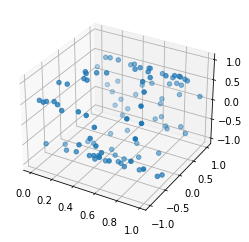

In [8]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,100)
noise=np.random.normal(0,0.1,100) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,100) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

In [24]:
st = gd.RipsComplex(points = X, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=3)
st.persistence() #computes persistence intervals

#extract persistence intervals for specified dim
D = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

#### 1 Dim Holes

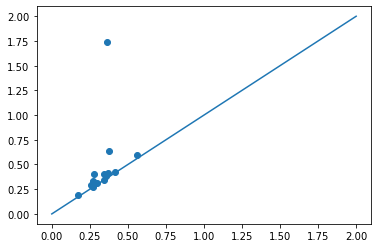

In [31]:
#1 dim holes

plt.figure()
#plots birth and death times
plt.scatter(D[:,0], D[:,1])
#plots x=y
plt.plot([0,2], [0,2])
plt.show()

#### 0 Dim Holes

In [26]:
D0 = np.array(st.persistence_intervals_in_dimension(0), dtype=np.float32)

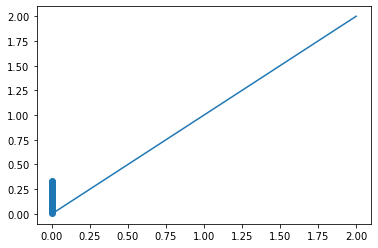

In [27]:
#1 dim holes

plt.figure()
#plots birth and death times
plt.scatter(D0[:,0], D0[:,1])
#plots x=y
plt.plot([0,2], [0,2])
plt.show()

#### Zhaoyang's PD

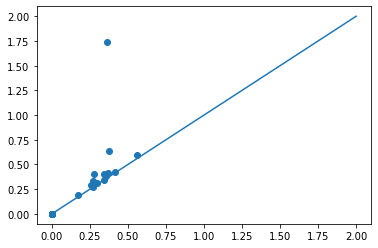

In [33]:
PD(X)

## Rips Model

In [5]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    
    
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, X, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        self.X = X
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        X = self.X

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

## Custom Accuracy

In [6]:
def whiten(X):
    return X/tf.math.reduce_std(X,axis=0)

In [7]:
def normalize(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_std(X,axis=0)

In [58]:
class CustomAccuracy1(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        
        #X = whiten(X)
        #Y = whiten(Y)
        
        #X = whiten(X)*(n_samples**(1/X.shape[1]))
#         X = X - tf.math.reduce_mean(X)
        #Y = whiten(Y)*(n_samples**(1/Y.shape[1]))
#         Y = Y - tf.math.reduce_mean(Y)
#         X = (X-tf.math.reduce_mean(X))/tf.math.reduce_std(X,axis=0)
#         Y = (Y-tf.math.reduce_mean(Y))/tf.math.reduce_std(Y,axis=0)
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y,X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        #sess=tf.compat.v1.InteractiveSession()
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        #print("D",D)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [8]:
class CustomAccuracy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):
        

        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(log(Zdgm), log(Xdgm), order=2, internal_p=2, enable_autodiff=True))


        return loss

In [9]:
class CustomAccuracy_normalize(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        

        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
#         print("Zdgm",Zdgm)
#         print("log Zdgm",log(Zdgm))
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        #print("D",D)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(log(Zdgm), log(Xdgm), order=2, internal_p=2, enable_autodiff=True))


        return loss

## Data from Interleaving DR Paper

In [2]:
def generate_circle(n = 100, p = 4, ind_x=0, ind_y=1, rad = 1, sigma = 0.05):
    # ind_x: the index of dimension where x-axis of cycle lies in
    # ind_y: the index of dimension where y-axis of cycle lies in
    
    thetas = np.arange(0, n) * 2 * np.pi / n
    rs = rad * np.ones(n)
    X = np.hstack((sigma*np.random.randn(n, ind_x),
                   (rs * np.cos(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, ind_y - ind_x - 1),
                   (rs * np.sin(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, p - ind_y -1)))
    
    return X

In [3]:
def generate_X(n_pt_cirlce, p):
#     p  : dimension of whole space
#     n_pt_cirlce : number of points in each circle
    X = generate_circle(n_pt_cirlce, p, 0, 1)
    labels = np.ones(len(X))
    k = 1
    for i in range(p):
        for j in range(i+1,p):
            if (i,j) != (0,1):
                X = np.vstack((X, generate_circle(n_pt_cirlce, p, i, j) ))
                labels = np.hstack((labels, np.ones(n_pt_cirlce) + k))
                k+=1
    return X, labels

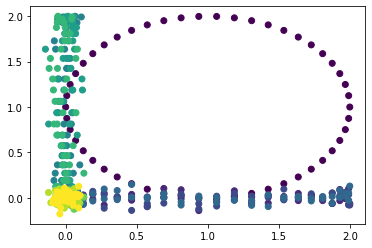

In [4]:
X, labels = generate_X(50, 5)
plt.scatter(X[:,0], X[:,1], c = labels)

In [5]:
def generate_n_tendrils(n_ten, p):
    '''
    n_ten: number of pts at each tendril
    p: column dimension/number of tendrills
    
    return 
    ------
    X: dataset with shape n_ten * p
    '''
    # generate random pts on the j-th tendril (canonical axis)
    X = np.random.uniform(size =(n_ten,1))
    # pad zeros
    X = np.c_[X, np.zeros((n_ten, p-1))]

    for j in range(1, p):
        # generate random pts on the j-th tendril (canonical axis)
        rand_pts = np.random.uniform(size =(n_ten,1))
        # pad zeros 
        rand_pts = np.c_[np.zeros((n_ten, j)), rand_pts]
        rand_pts = np.c_[rand_pts, np.zeros((n_ten,p-j-1))]
        X = np.r_[X, rand_pts]
    
    return X

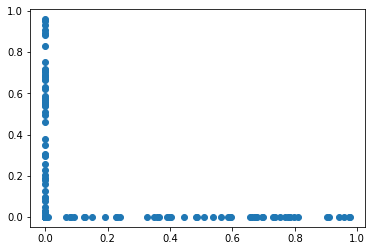

In [10]:
X = generate_n_tendrils(50,5)
plt.scatter(X[:,0], X[:,1])

# 1 Cylinder

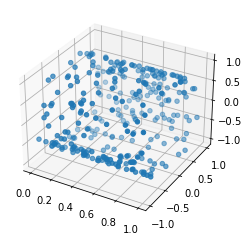

In [99]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

# Multiplying by Matricies

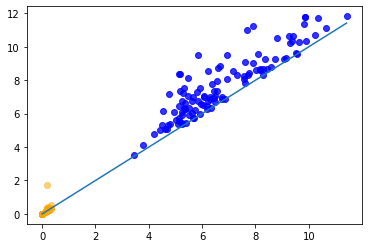

In [73]:
#A = np.random.normal(size = (300,300))
A = np.random.normal(size = (300,300))
B=A@X
B = B.astype("float32")
modelR = RipsModel(P=B, mel=12, dim=1, card = 150)

Zdgm = modelR.call()[1]
D = Zdgm.numpy()      
plt.figure()
plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
#print("D",D)
Xdgm = modelR.call()[0]
D1 = Xdgm.numpy()
plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
line = max(max(D1[:,0]),max(D[:,0]))
plt.plot([0,line],[0,line])
plt.show()

#try random diagonal matrix, and see what we get for the persistence diagram 

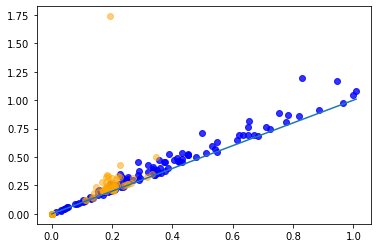

In [74]:
#A = np.random.normal(size = (300,300))
n = 100
vec = np.random.normal(size = (300,))
mat = np.diag(vec)
B = mat@X
B = B.astype("float32")

modelR = RipsModel(P=B, mel=12, dim=1, card = 150)

Zdgm = modelR.call()[1]
D = Zdgm.numpy()      
plt.figure()
plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
#print("D",D)
Xdgm = modelR.call()[0]
D1 = Xdgm.numpy()
plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
line = max(max(D1[:,0]),max(D[:,0]))
plt.plot([0,line],[0,line])
plt.show()

In [60]:
n = 100
vec = np.random.choice([-1,1],n)
mat = np.diag(vec)

In [69]:
n = 100
vec = np.random.normal(size = (300,))
mat = np.diag(vec)

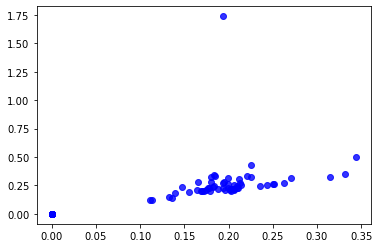

In [33]:
#Make A a diagonal random matrix
A = np.random.normal(size = (300,300))
B=A@X
B = B.astype("float32")
modelR = RipsModel(P=X, mel=12, dim=1, card = 150)
Zdgm = modelR.call()[1]
D = Zdgm.numpy()      
plt.figure()
plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)

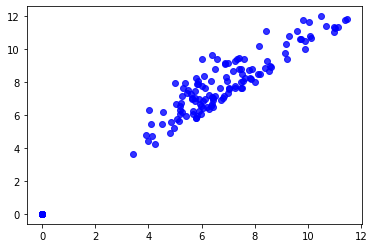

In [49]:
A = np.random.normal(size = (300,300))
modelR = RipsModel(P=B, mel=12, dim=1, card = 150)
Zdgm = modelR.call()[1]
D = Zdgm.numpy()      
plt.figure()
plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)

# Whitening

In [13]:
class CustomAccuracy_whiten(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        #X = normalize(X) #*(n_samples**(1/X.shape[1]))
        #Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        
        X = whiten(X)
        Y = whiten(Y)
        
        #X = whiten(X)*(n_samples**(1/X.shape[1]))
#         X = X - tf.math.reduce_mean(X)
        #Y = whiten(Y)*(n_samples**(1/Y.shape[1]))
#         Y = Y - tf.math.reduce_mean(Y)
#         X = (X-tf.math.reduce_mean(X))/tf.math.reduce_std(X,axis=0)
#         Y = (Y-tf.math.reduce_mean(Y))/tf.math.reduce_std(Y,axis=0)
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        #sess=tf.compat.v1.InteractiveSession()
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        #print("D",D)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

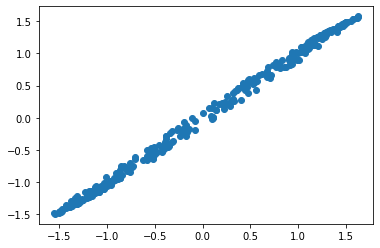

x <class 'numpy.ndarray'>
x <class 'numpy.ndarray'>


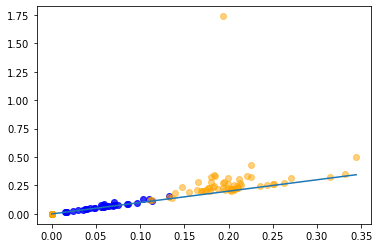

1/1 [==============================] - 6s 6s/step - loss: 1.3276


In [63]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_whiten(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

### Normalizing

Epoch 1/5


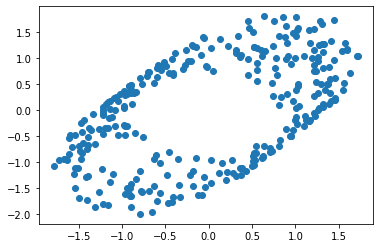

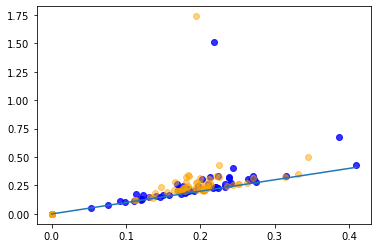

1/1 [==============================] - 7s 7s/step - loss: 0.1096
Epoch 2/5


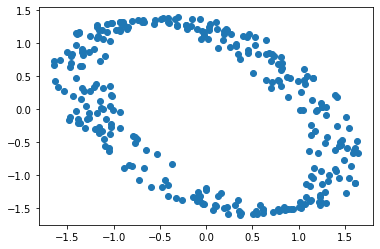

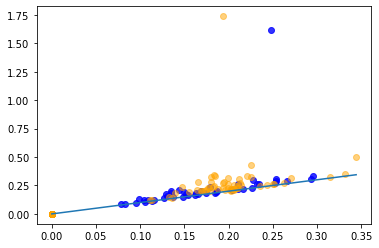

1/1 [==============================] - 7s 7s/step - loss: 0.1036
Epoch 3/5


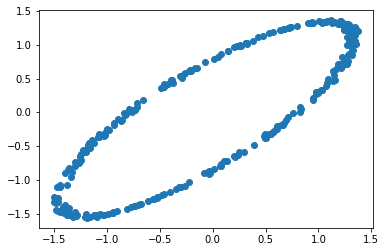

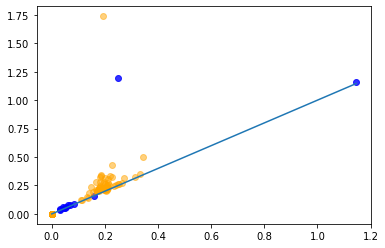

1/1 [==============================] - 7s 7s/step - loss: 0.4310
Epoch 4/5


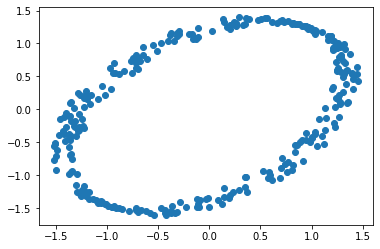

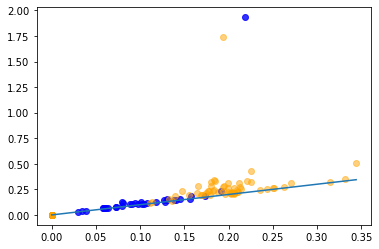

1/1 [==============================] - 7s 7s/step - loss: 0.1726
Epoch 5/5


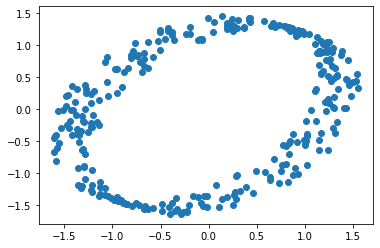

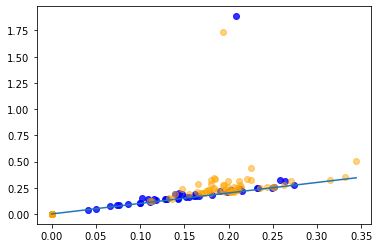

1/1 [==============================] - 8s 8s/step - loss: 0.1306


In [35]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Random Uniform initial weights with learning rate = 0.2

Observation: lower than 0.2 learning rate performed better

Epoch 1/5


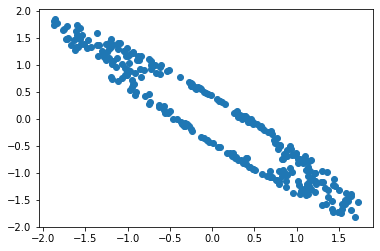

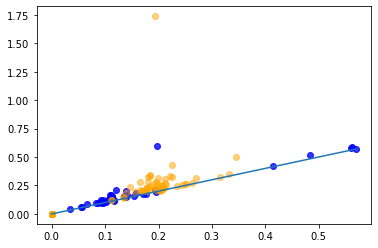

1/1 [==============================] - 7s 7s/step - loss: 1.3316
Epoch 2/5


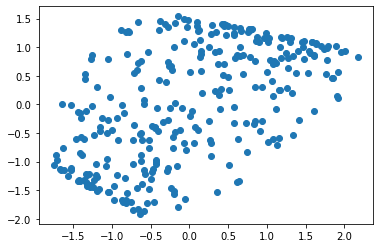

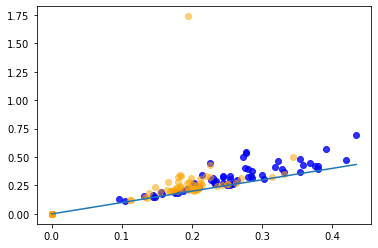

1/1 [==============================] - 7s 7s/step - loss: 1.2992
Epoch 3/5


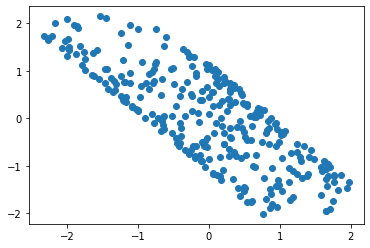

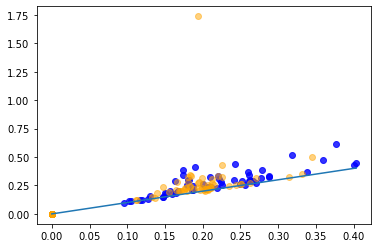

1/1 [==============================] - 7s 7s/step - loss: 1.2604
Epoch 4/5


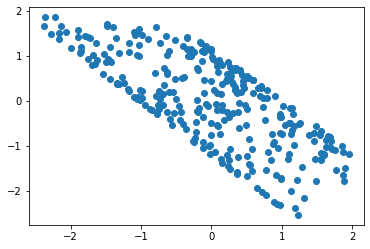

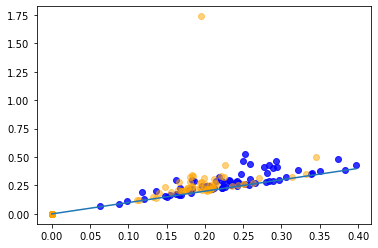

1/1 [==============================] - 8s 8s/step - loss: 1.2918
Epoch 5/5


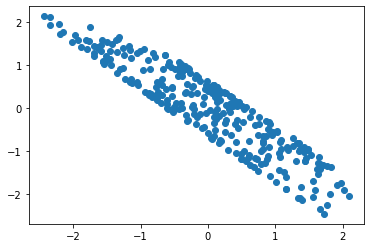

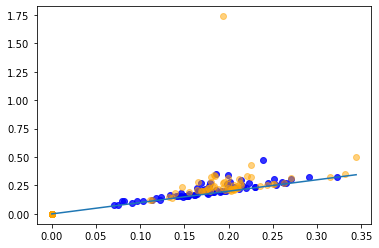

1/1 [==============================] - 7s 7s/step - loss: 1.2280


In [38]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Normalizing + Adjust for Dimension

Observation: Scale is off

Epoch 1/5


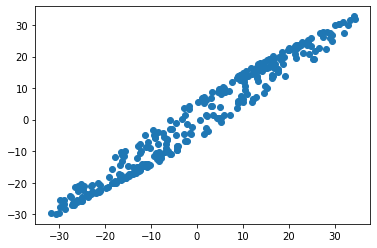

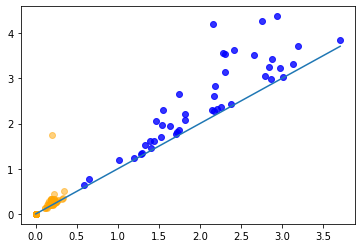

1/1 [==============================] - 4s 4s/step - loss: 10.4017
Epoch 2/5


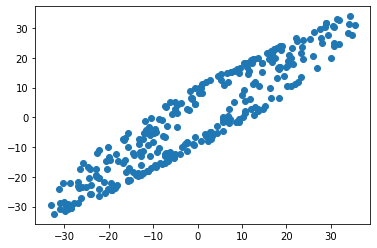

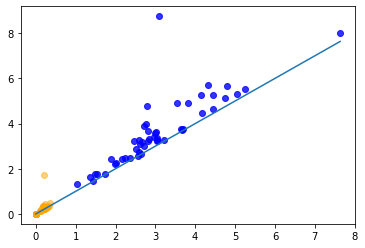

1/1 [==============================] - 4s 4s/step - loss: 26.8536
Epoch 3/5


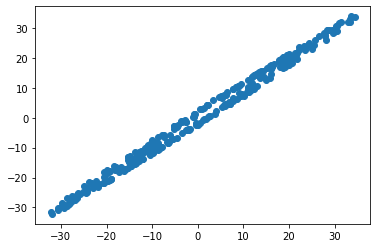

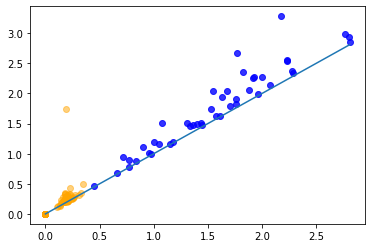

1/1 [==============================] - 4s 4s/step - loss: 2.8438
Epoch 4/5


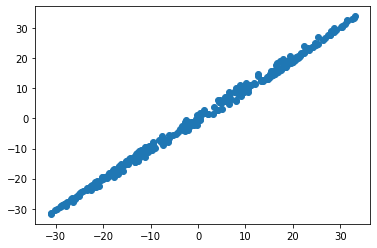

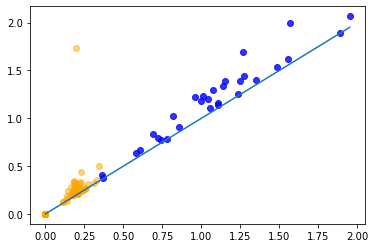

1/1 [==============================] - 4s 4s/step - loss: 1.3738
Epoch 5/5


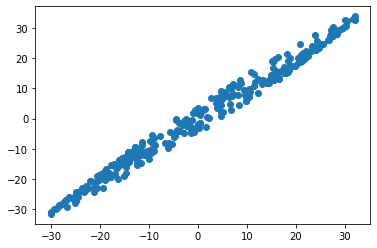

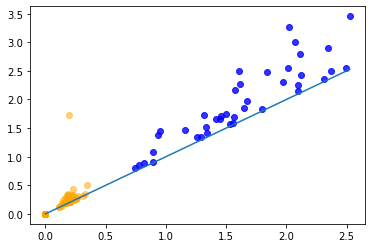

1/1 [==============================] - 4s 4s/step - loss: 4.5214


In [31]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Random Normal initial weights  with learning rate = 0.2

Observation: 

* Random Normal intial weights performs better with higher learning rate
* Random Uniform initial weights performs better with lower learning rate



Epoch 1/5


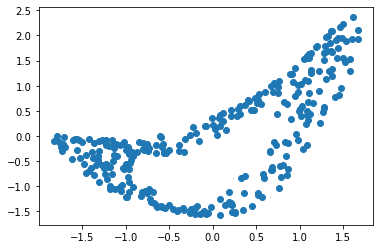

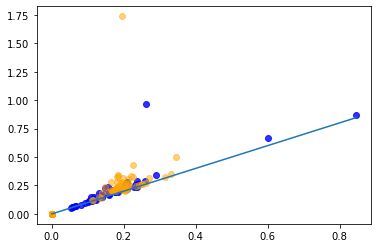

1/1 [==============================] - 7s 7s/step - loss: 0.6827
Epoch 2/5


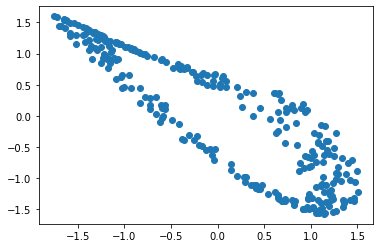

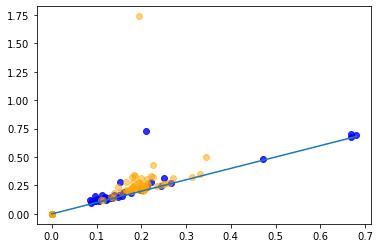

1/1 [==============================] - 7s 7s/step - loss: 1.1242
Epoch 3/5


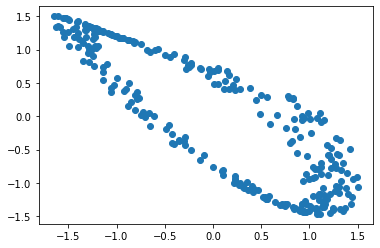

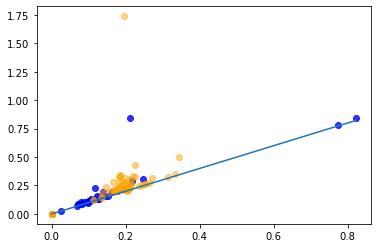

1/1 [==============================] - 7s 7s/step - loss: 0.9081
Epoch 4/5


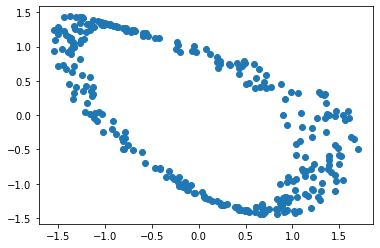

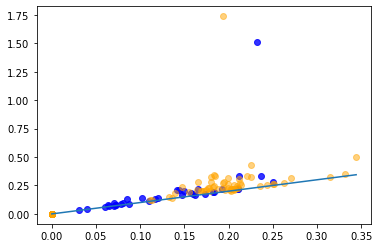

1/1 [==============================] - 7s 7s/step - loss: 0.1542
Epoch 5/5


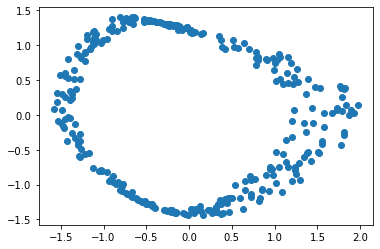

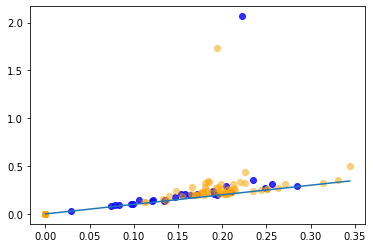

1/1 [==============================] - 7s 7s/step - loss: 0.1991


In [37]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

## Random Normal (learning rate = 0.2) vs. Random Uniform (learning rate = 0.01)

These are not the optimal parameters.

Epoch 1/50


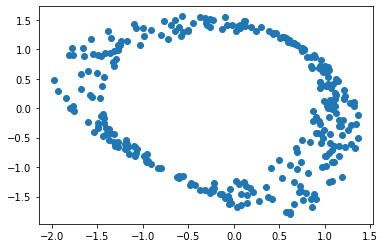

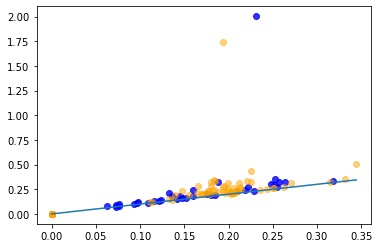

1/1 [==============================] - 8s 8s/step - loss: 0.1416
Epoch 2/50


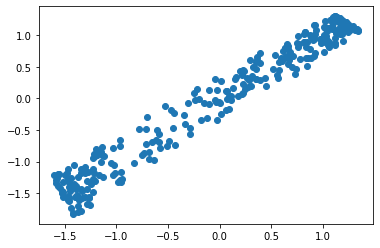

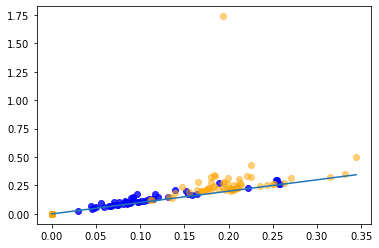

1/1 [==============================] - 8s 8s/step - loss: 1.3111
Epoch 3/50


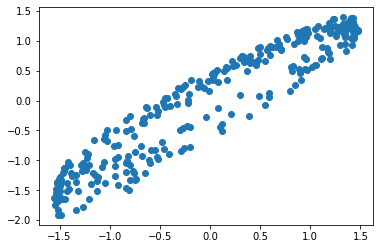

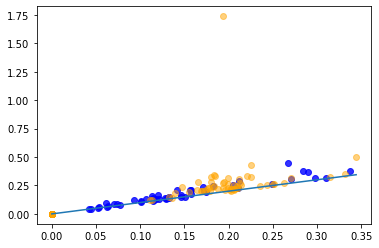

1/1 [==============================] - 8s 8s/step - loss: 1.2750
Epoch 4/50


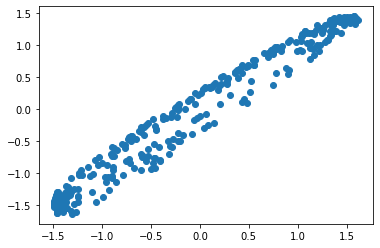

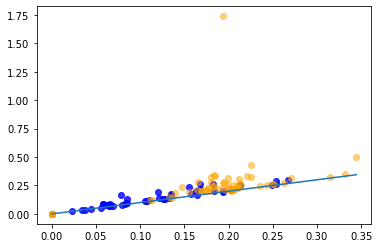

1/1 [==============================] - 8s 8s/step - loss: 1.2952
Epoch 5/50


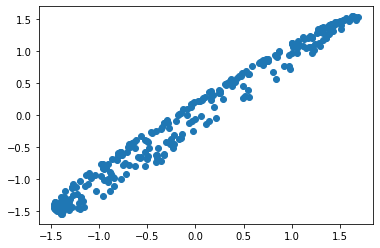

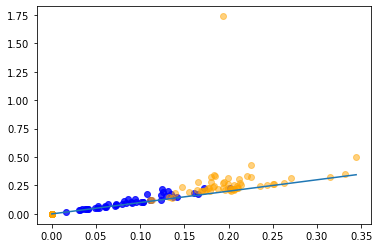

1/1 [==============================] - 7s 7s/step - loss: 1.3212
Epoch 6/50


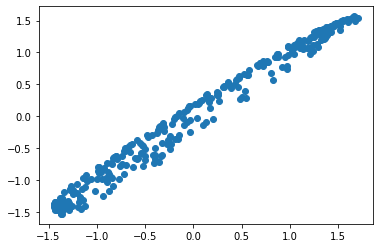

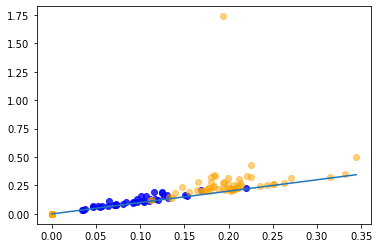

1/1 [==============================] - 7s 7s/step - loss: 1.3284
Epoch 7/50


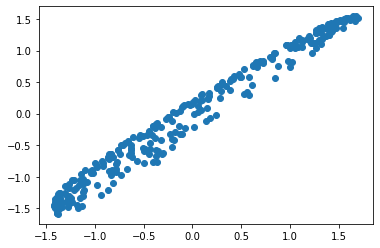

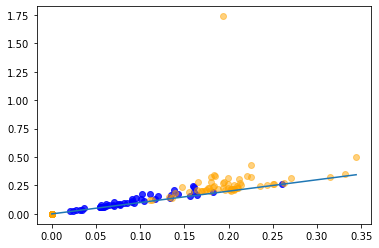

1/1 [==============================] - 7s 7s/step - loss: 1.3182
Epoch 8/50


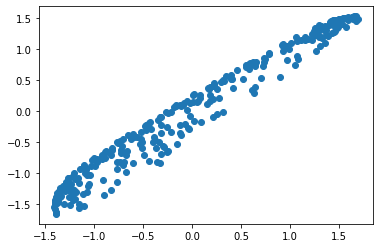

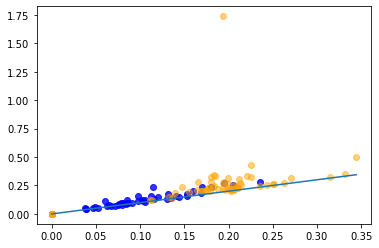

1/1 [==============================] - 7s 7s/step - loss: 1.3003
Epoch 9/50


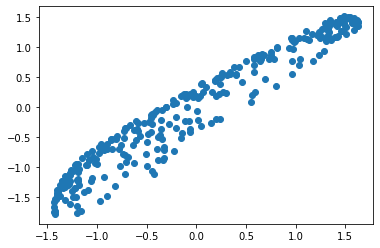

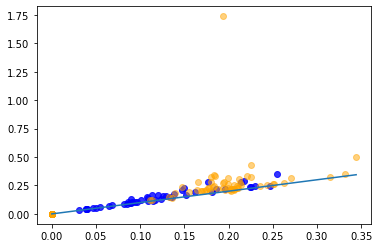

1/1 [==============================] - 7s 7s/step - loss: 1.2783
Epoch 10/50


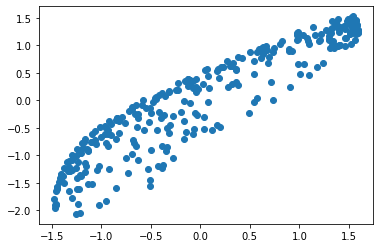

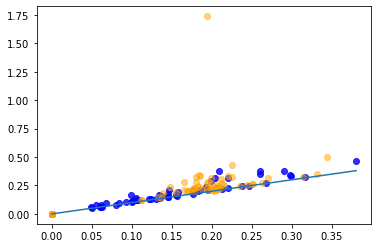

1/1 [==============================] - 7s 7s/step - loss: 1.2477
Epoch 11/50


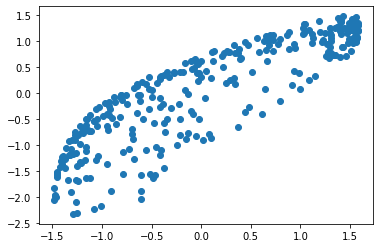

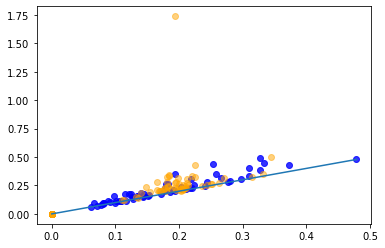

1/1 [==============================] - 7s 7s/step - loss: 1.2525
Epoch 12/50


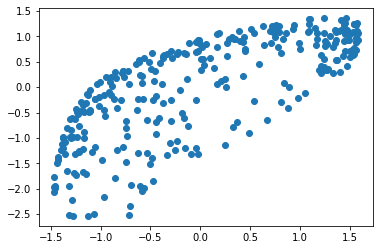

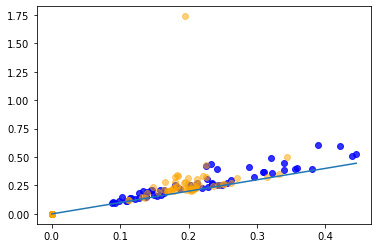

1/1 [==============================] - 7s 7s/step - loss: 1.3024
Epoch 13/50


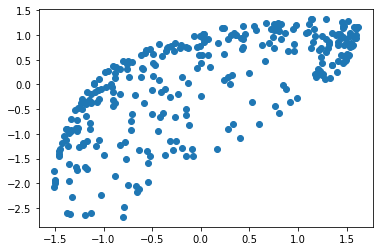

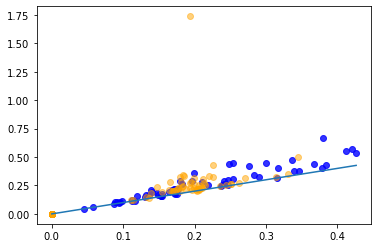

1/1 [==============================] - 7s 7s/step - loss: 1.2771
Epoch 14/50


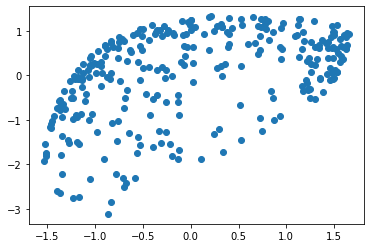

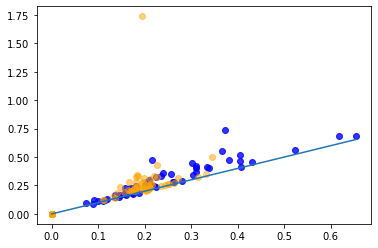

1/1 [==============================] - 7s 7s/step - loss: 1.1042
Epoch 15/50


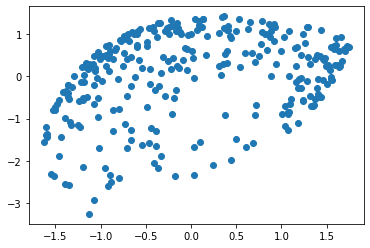

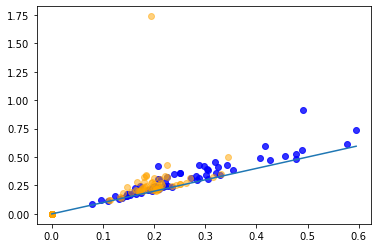

1/1 [==============================] - 7s 7s/step - loss: 0.8705
Epoch 16/50


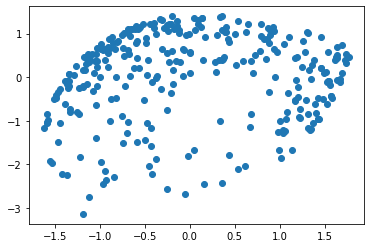

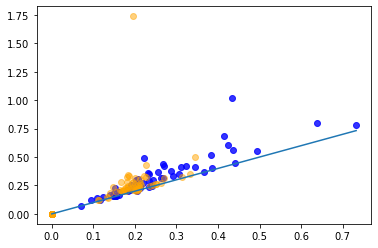

1/1 [==============================] - 7s 7s/step - loss: 0.7183
Epoch 17/50


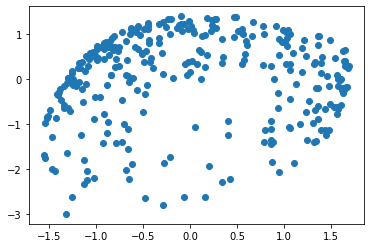

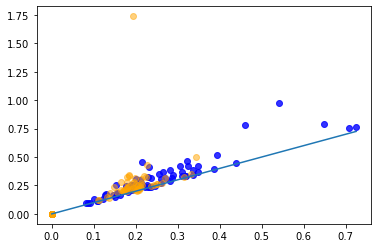

1/1 [==============================] - 7s 7s/step - loss: 0.8301
Epoch 18/50


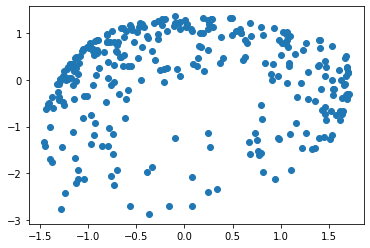

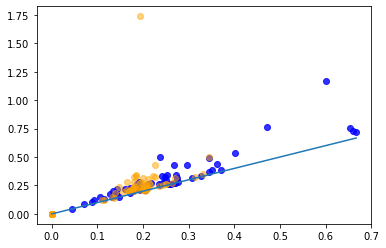

1/1 [==============================] - 7s 7s/step - loss: 0.6146
Epoch 19/50


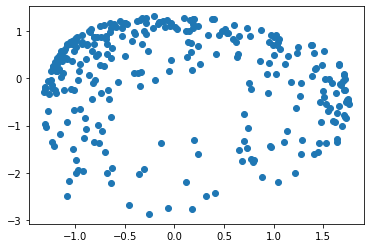

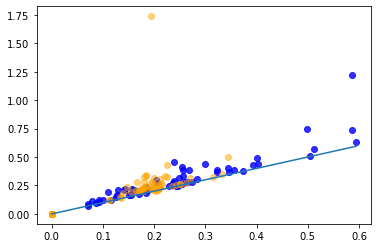

1/1 [==============================] - 7s 7s/step - loss: 0.5389
Epoch 20/50


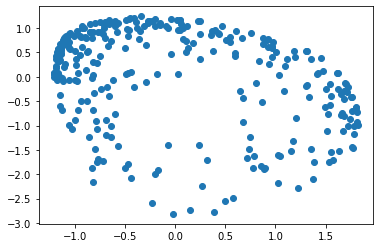

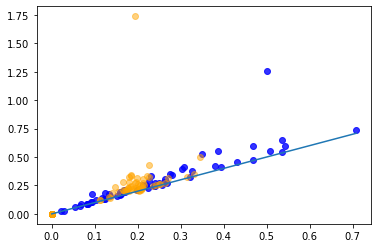

1/1 [==============================] - 7s 7s/step - loss: 0.4246
Epoch 21/50


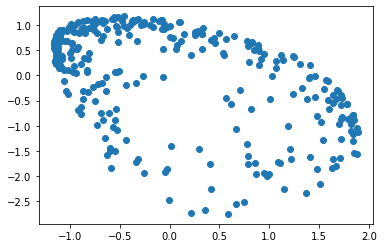

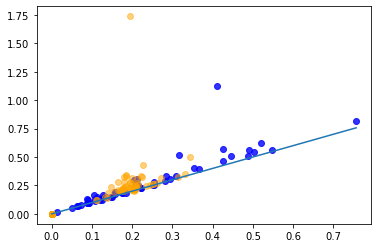

1/1 [==============================] - 7s 7s/step - loss: 0.5195
Epoch 22/50


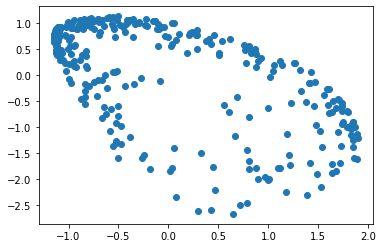

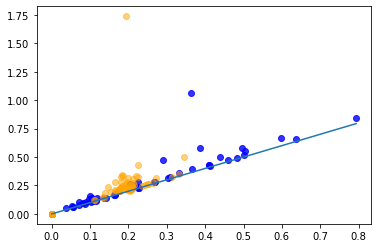

1/1 [==============================] - 8s 8s/step - loss: 0.5866
Epoch 23/50


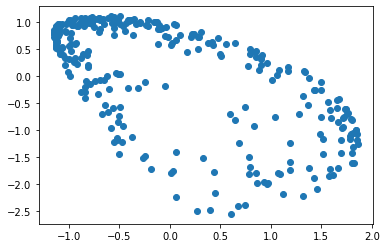

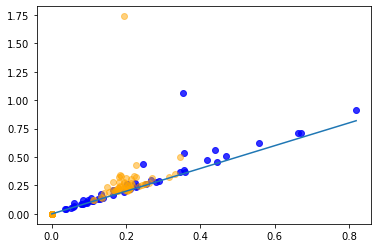

1/1 [==============================] - 8s 8s/step - loss: 0.5798
Epoch 24/50


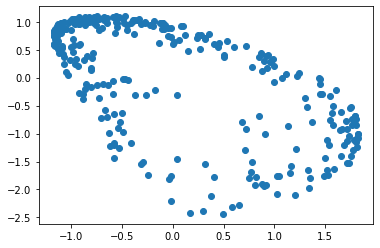

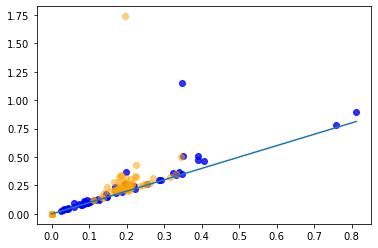

1/1 [==============================] - 7s 7s/step - loss: 0.4735
Epoch 25/50


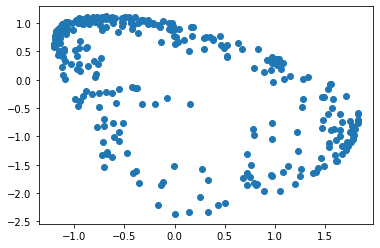

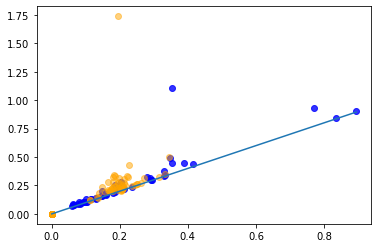

1/1 [==============================] - 7s 7s/step - loss: 0.5265
Epoch 26/50


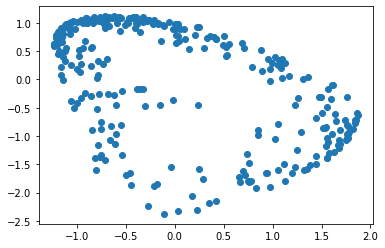

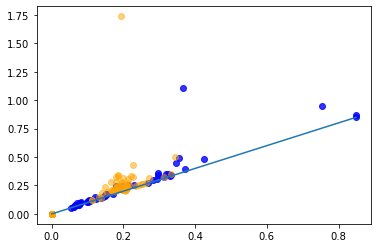

1/1 [==============================] - 7s 7s/step - loss: 0.5435
Epoch 27/50


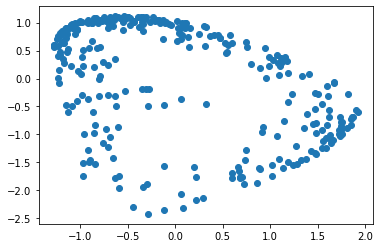

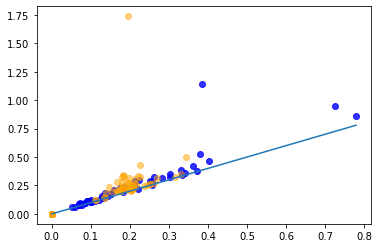

1/1 [==============================] - 7s 7s/step - loss: 0.4985
Epoch 28/50


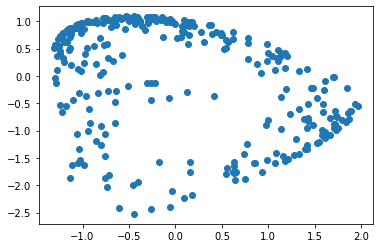

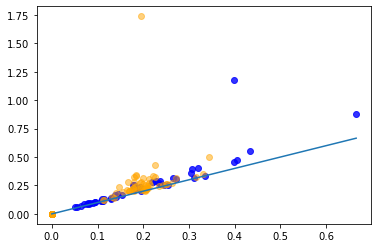

1/1 [==============================] - 8s 8s/step - loss: 0.4524
Epoch 29/50


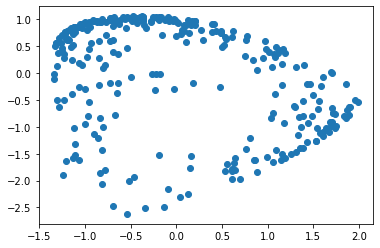

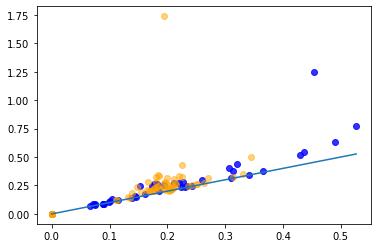

1/1 [==============================] - 7s 7s/step - loss: 0.4279
Epoch 30/50


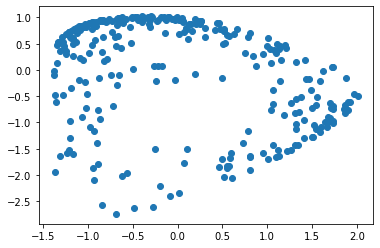

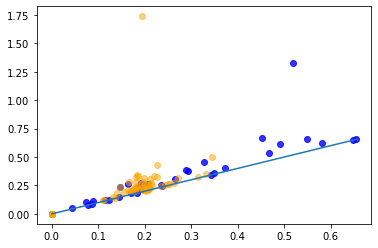

1/1 [==============================] - 7s 7s/step - loss: 0.3807
Epoch 31/50


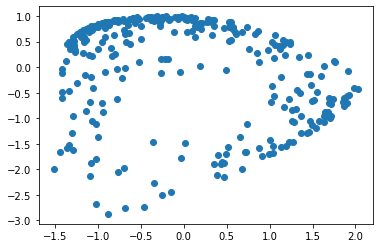

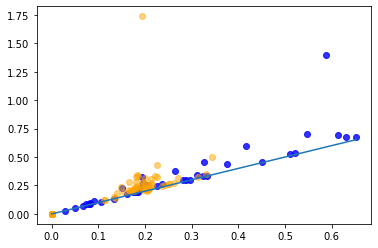

1/1 [==============================] - 7s 7s/step - loss: 0.3726
Epoch 32/50


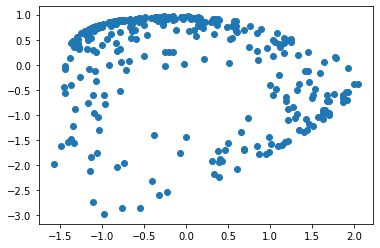

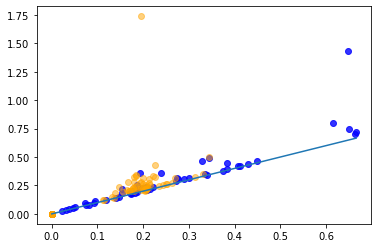

1/1 [==============================] - 7s 7s/step - loss: 0.3901
Epoch 33/50


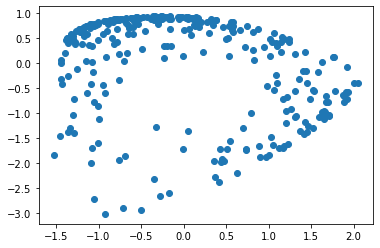

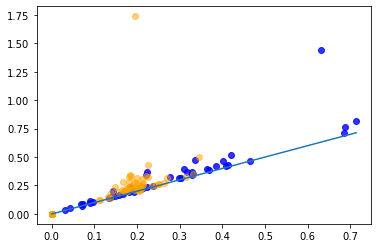

1/1 [==============================] - 8s 8s/step - loss: 0.3659
Epoch 34/50


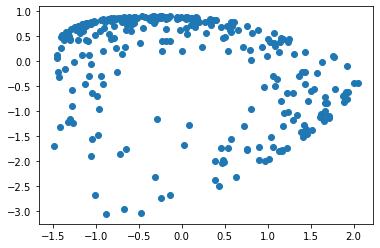

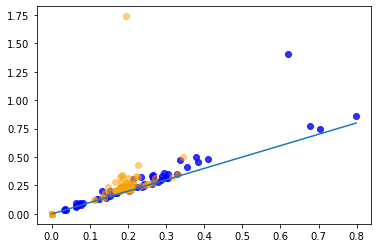

1/1 [==============================] - 7s 7s/step - loss: 0.3749
Epoch 35/50


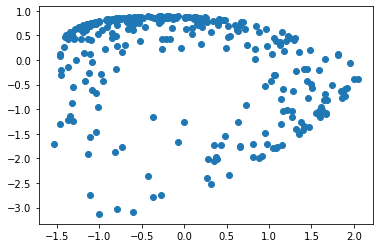

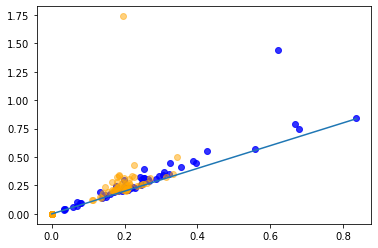

1/1 [==============================] - 8s 8s/step - loss: 0.3503
Epoch 36/50


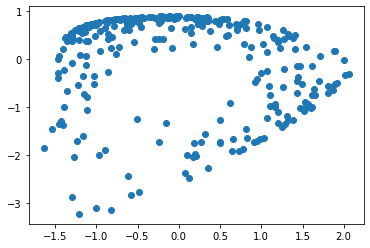

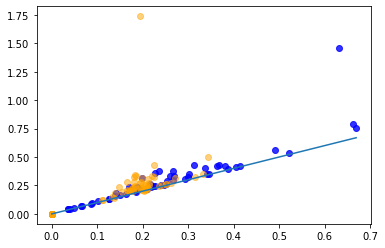

1/1 [==============================] - 7s 7s/step - loss: 0.3413
Epoch 37/50


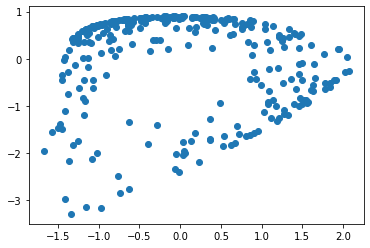

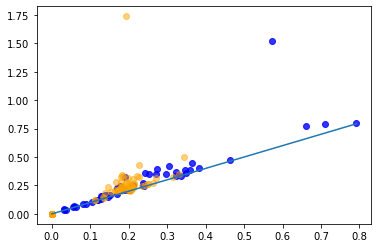

1/1 [==============================] - 7s 7s/step - loss: 0.2622
Epoch 38/50


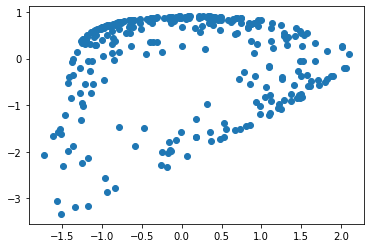

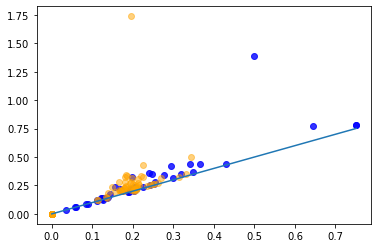

1/1 [==============================] - 7s 7s/step - loss: 0.2846
Epoch 39/50


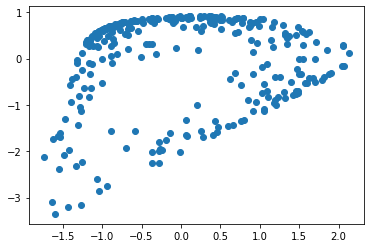

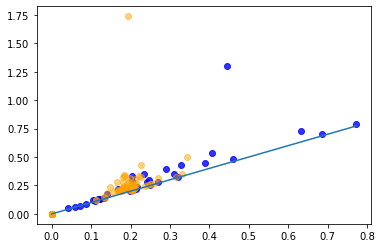

1/1 [==============================] - 7s 7s/step - loss: 0.3261
Epoch 40/50


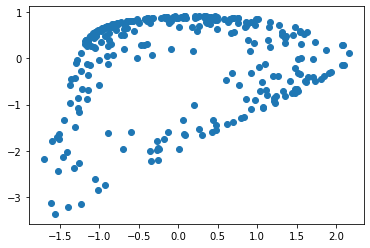

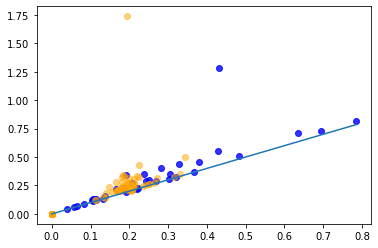

1/1 [==============================] - 7s 7s/step - loss: 0.3363
Epoch 41/50


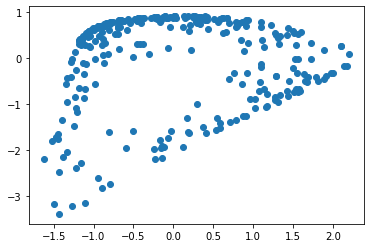

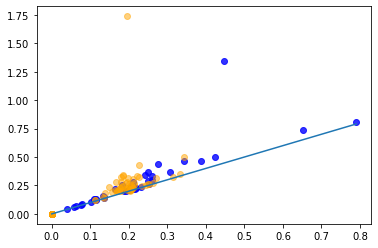

1/1 [==============================] - 8s 8s/step - loss: 0.2855
Epoch 42/50


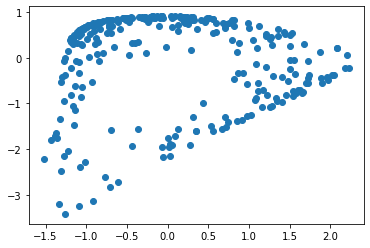

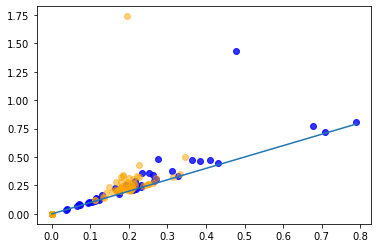

1/1 [==============================] - 7s 7s/step - loss: 0.2401
Epoch 43/50


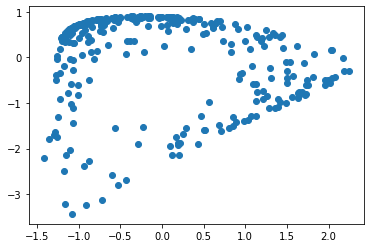

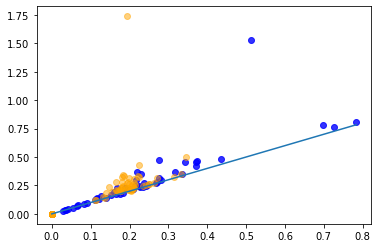

1/1 [==============================] - 7s 7s/step - loss: 0.2202
Epoch 44/50


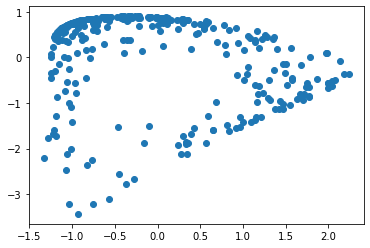

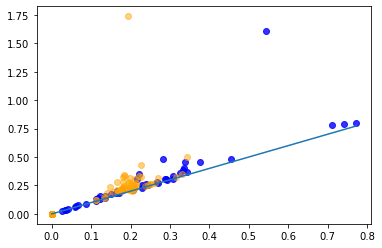

1/1 [==============================] - 8s 8s/step - loss: 0.2241
Epoch 45/50


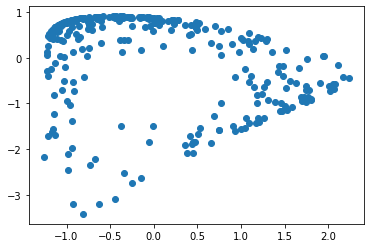

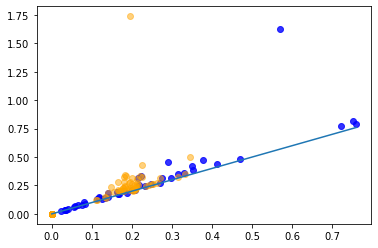

1/1 [==============================] - 7s 7s/step - loss: 0.2347
Epoch 46/50


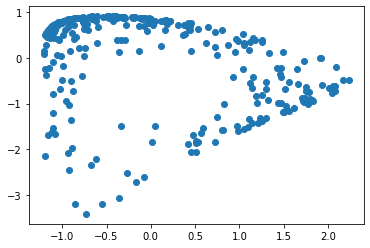

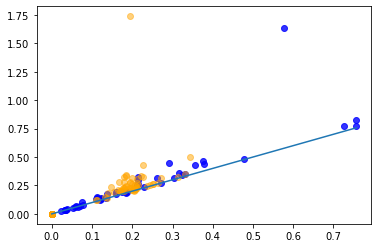

1/1 [==============================] - 7s 7s/step - loss: 0.2369
Epoch 47/50


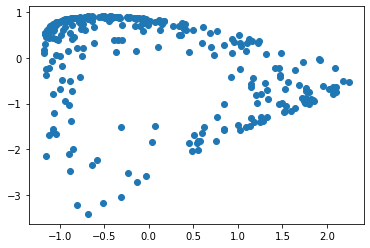

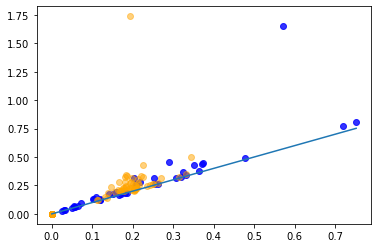

1/1 [==============================] - 7s 7s/step - loss: 0.2323
Epoch 48/50


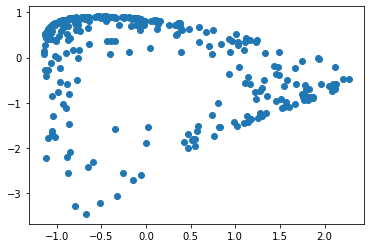

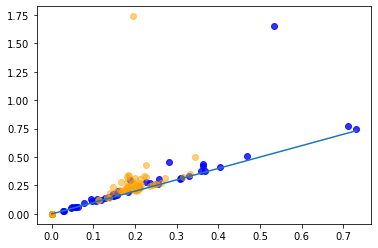

1/1 [==============================] - 7s 7s/step - loss: 0.2033
Epoch 49/50


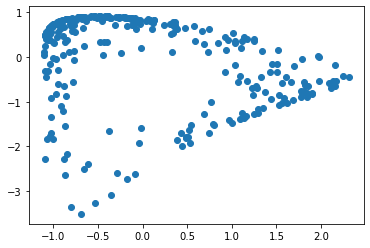

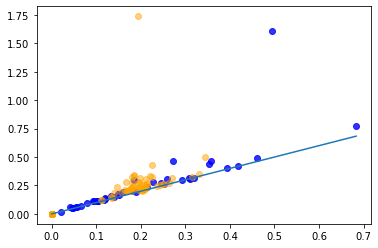

1/1 [==============================] - 7s 7s/step - loss: 0.1933
Epoch 50/50


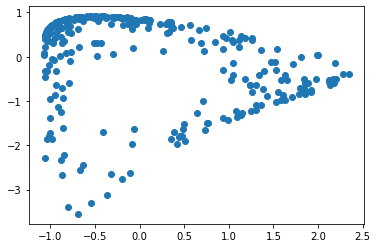

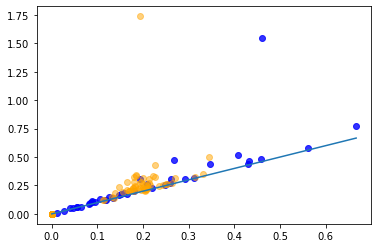

1/1 [==============================] - 7s 7s/step - loss: 0.1989


In [58]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=50,batch_size=n_samples)

Question: The projection is making a hole. How do we know the hole is in the right place?

Epoch 1/50


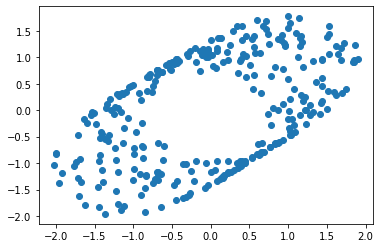

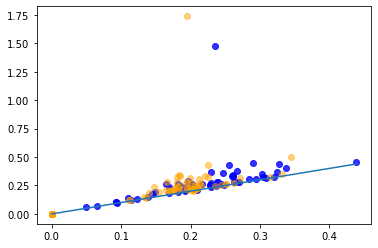

1/1 [==============================] - 8s 8s/step - loss: 0.1184
Epoch 2/50


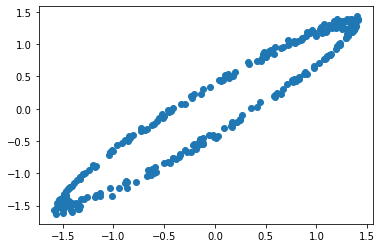

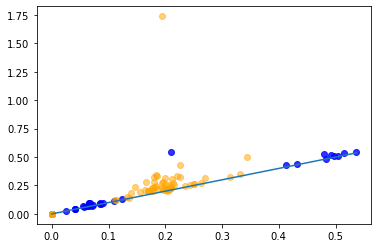

1/1 [==============================] - 8s 8s/step - loss: 1.3173
Epoch 3/50


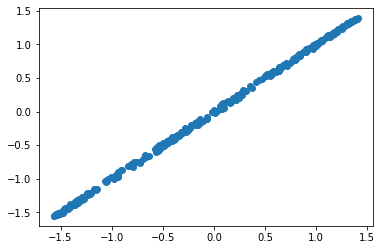

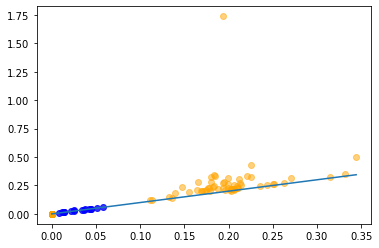

1/1 [==============================] - 8s 8s/step - loss: 1.3262
Epoch 4/50


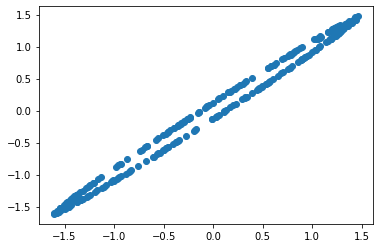

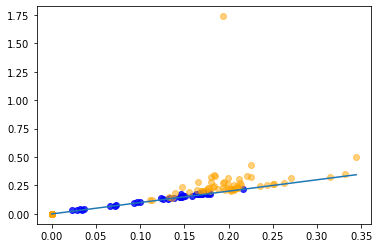

1/1 [==============================] - 8s 8s/step - loss: 1.3225
Epoch 5/50


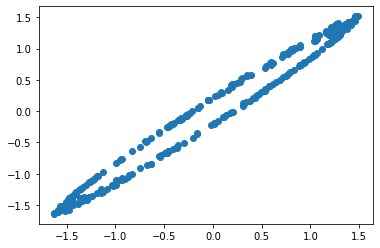

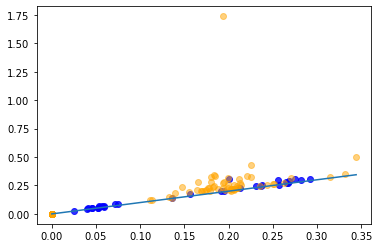

1/1 [==============================] - 7s 7s/step - loss: 1.2957
Epoch 6/50


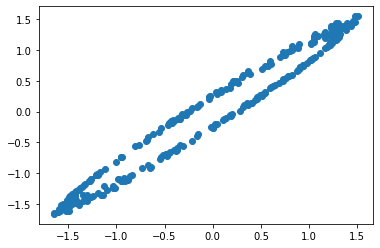

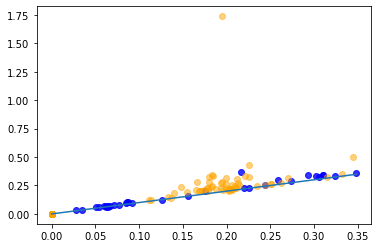

1/1 [==============================] - 8s 8s/step - loss: 1.2985
Epoch 7/50


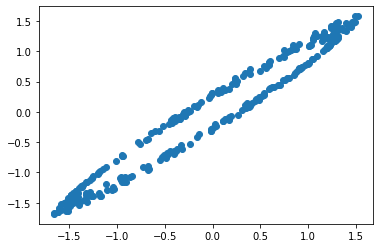

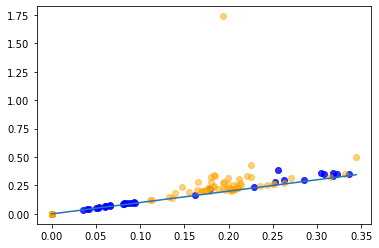

1/1 [==============================] - 7s 7s/step - loss: 1.2994
Epoch 8/50


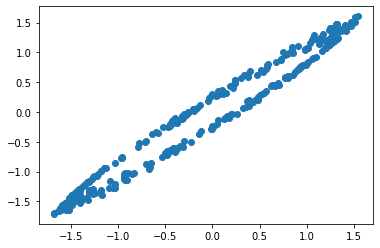

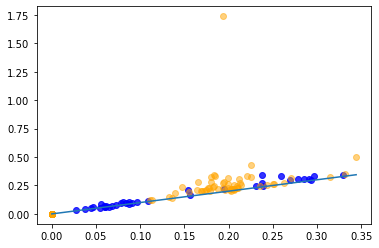

1/1 [==============================] - 7s 7s/step - loss: 1.2903
Epoch 9/50


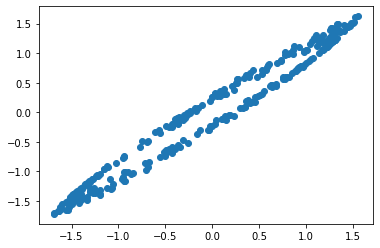

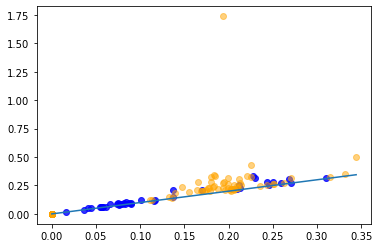

1/1 [==============================] - 8s 8s/step - loss: 1.2821
Epoch 10/50


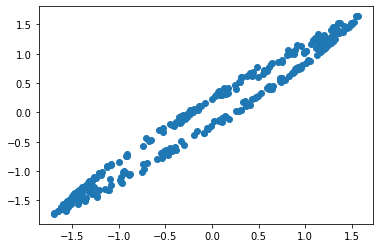

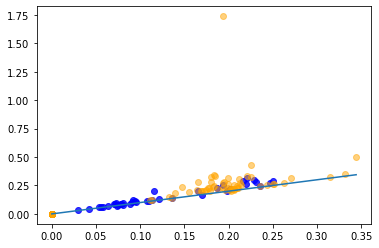

1/1 [==============================] - 8s 8s/step - loss: 1.2747
Epoch 11/50


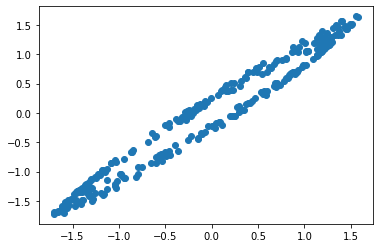

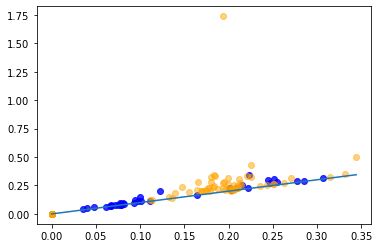

1/1 [==============================] - 8s 8s/step - loss: 1.2847
Epoch 12/50


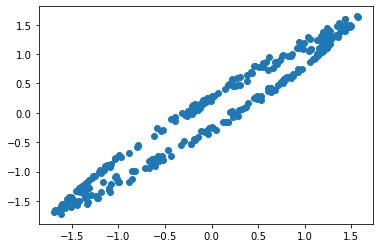

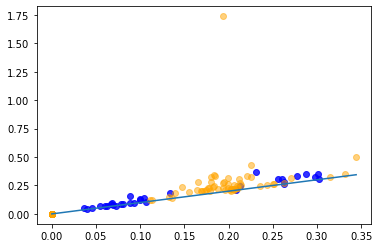

1/1 [==============================] - 8s 8s/step - loss: 1.2915
Epoch 13/50


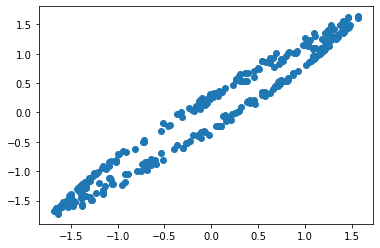

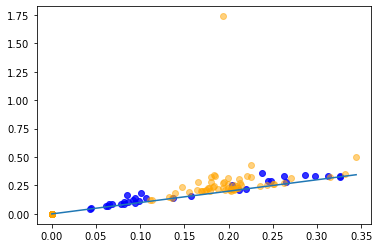

1/1 [==============================] - 7s 7s/step - loss: 1.2907
Epoch 14/50


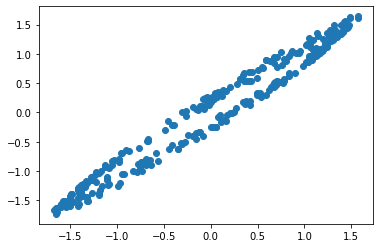

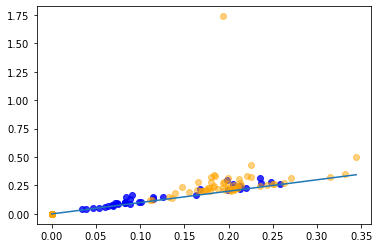

1/1 [==============================] - 7s 7s/step - loss: 1.2877
Epoch 15/50


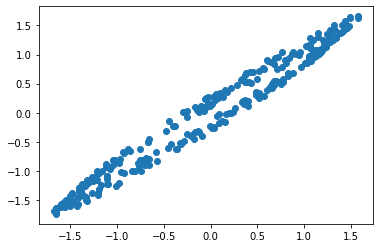

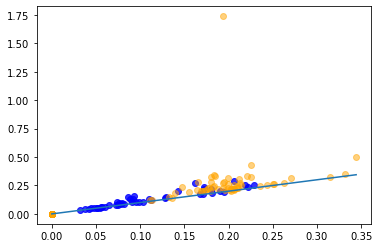

1/1 [==============================] - 7s 7s/step - loss: 1.2976
Epoch 16/50


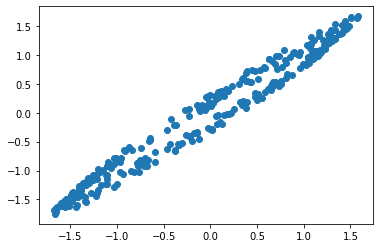

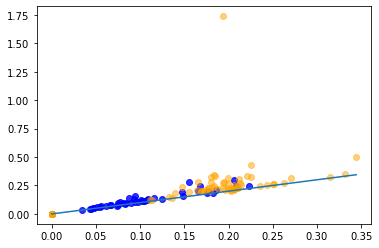

1/1 [==============================] - 7s 7s/step - loss: 1.2971
Epoch 17/50


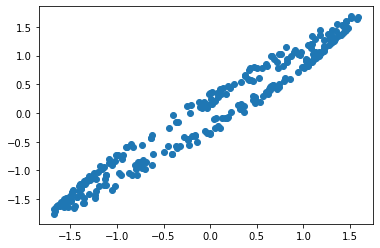

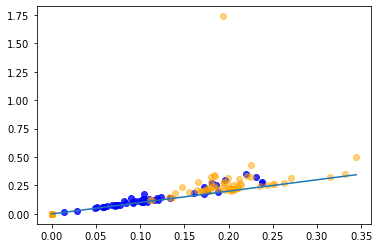

1/1 [==============================] - 7s 7s/step - loss: 1.2686
Epoch 18/50


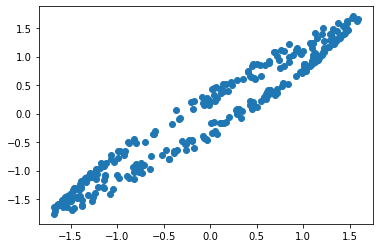

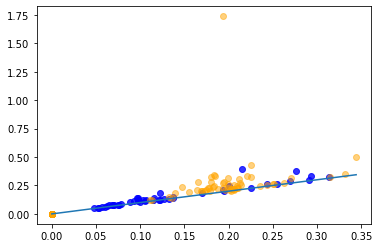

1/1 [==============================] - 7s 7s/step - loss: 1.2904
Epoch 19/50


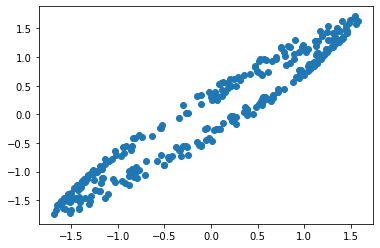

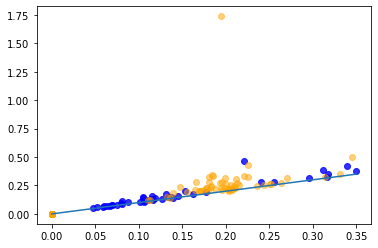

1/1 [==============================] - 8s 8s/step - loss: 1.2897
Epoch 20/50


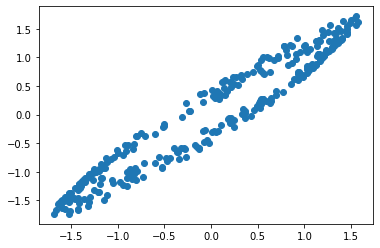

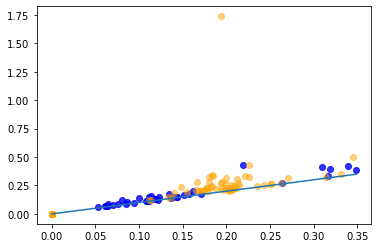

1/1 [==============================] - 7s 7s/step - loss: 1.3038
Epoch 21/50


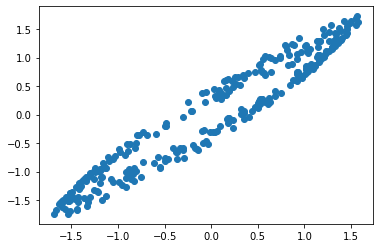

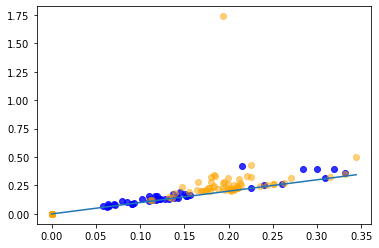

1/1 [==============================] - 7s 7s/step - loss: 1.3051
Epoch 22/50


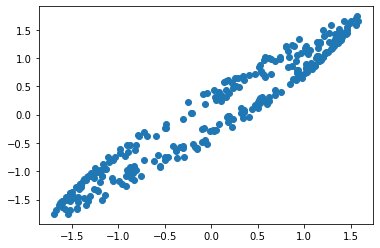

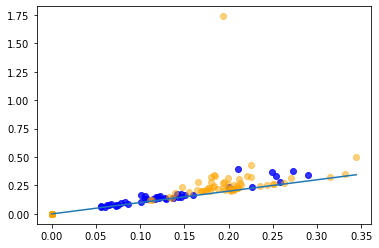

1/1 [==============================] - 7s 7s/step - loss: 1.2856
Epoch 23/50


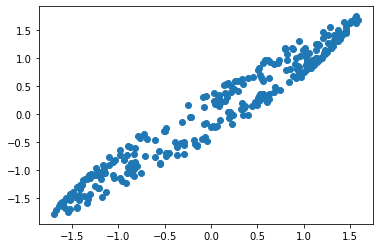

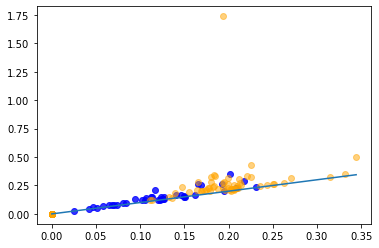

1/1 [==============================] - 8s 8s/step - loss: 1.2845
Epoch 24/50


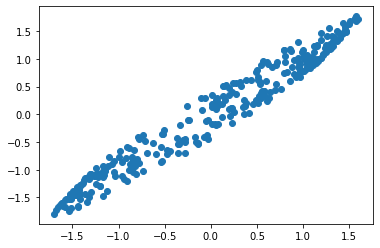

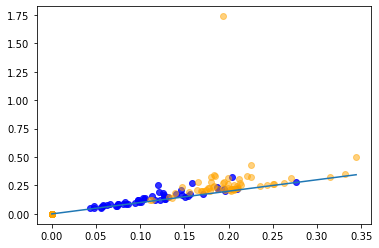

1/1 [==============================] - 7s 7s/step - loss: 1.2991
Epoch 25/50


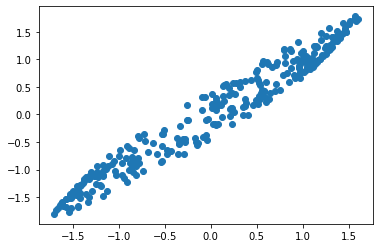

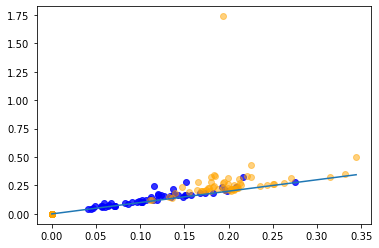

1/1 [==============================] - 7s 7s/step - loss: 1.2990
Epoch 26/50


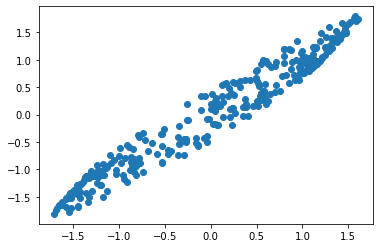

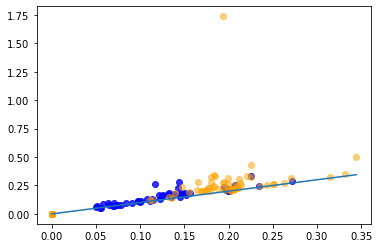

1/1 [==============================] - 7s 7s/step - loss: 1.2908
Epoch 27/50


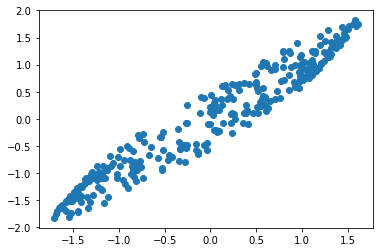

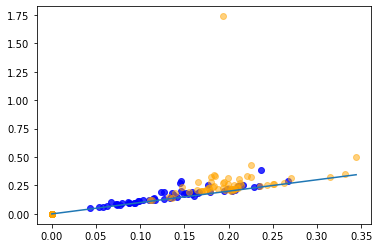

1/1 [==============================] - 7s 7s/step - loss: 1.2711
Epoch 28/50


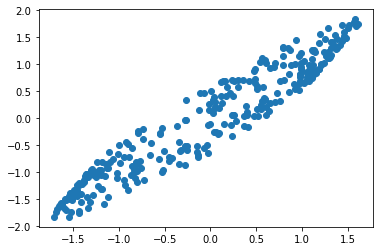

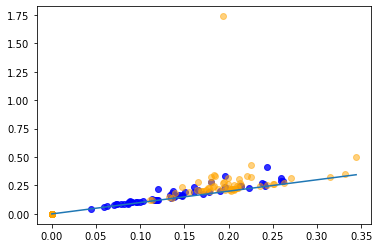

1/1 [==============================] - 7s 7s/step - loss: 1.2524
Epoch 29/50


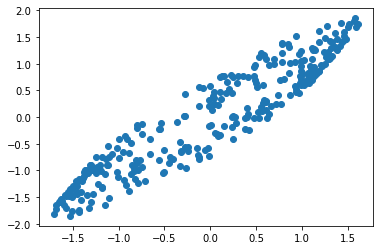

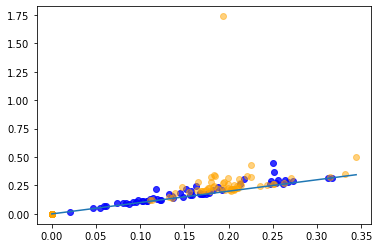

1/1 [==============================] - 7s 7s/step - loss: 1.2561
Epoch 30/50


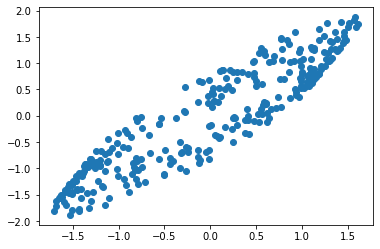

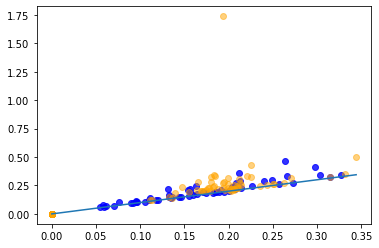

1/1 [==============================] - 7s 7s/step - loss: 1.2449
Epoch 31/50


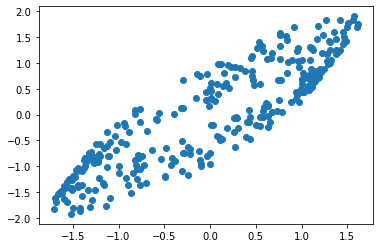

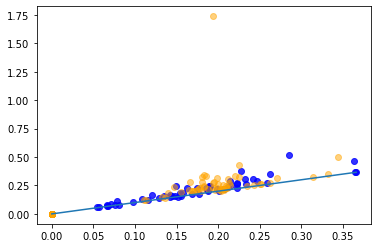

1/1 [==============================] - 7s 7s/step - loss: 1.2360
Epoch 32/50


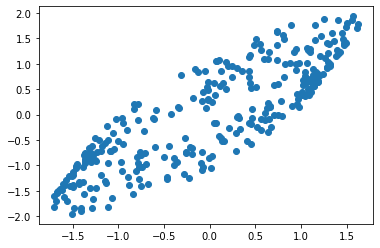

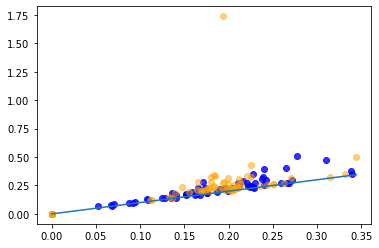

1/1 [==============================] - 7s 7s/step - loss: 1.2349
Epoch 33/50


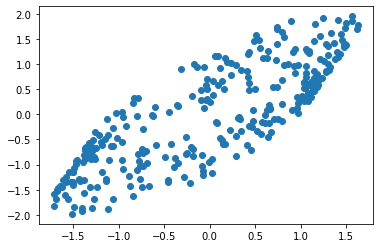

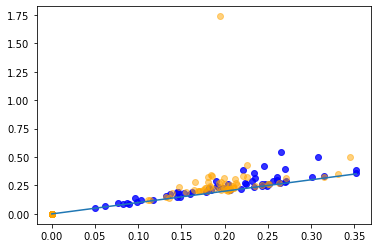

1/1 [==============================] - 7s 7s/step - loss: 1.2508
Epoch 34/50


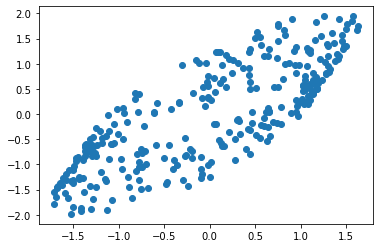

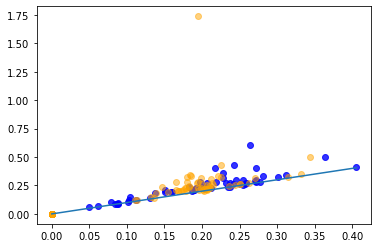

1/1 [==============================] - 7s 7s/step - loss: 1.2555
Epoch 35/50


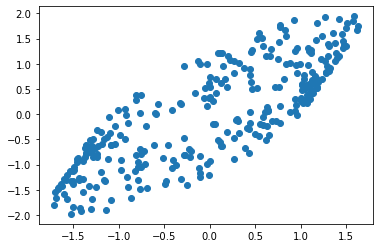

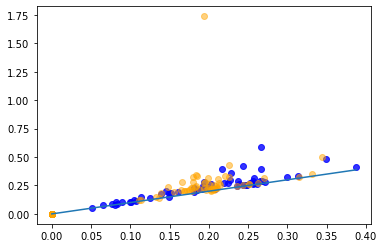

1/1 [==============================] - 7s 7s/step - loss: 1.2492
Epoch 36/50


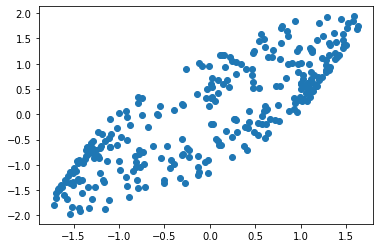

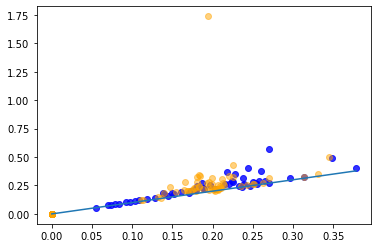

1/1 [==============================] - 7s 7s/step - loss: 1.2433
Epoch 37/50


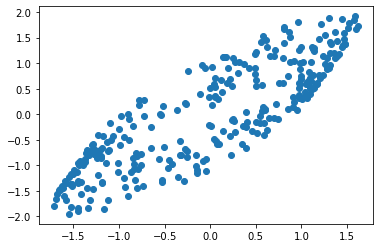

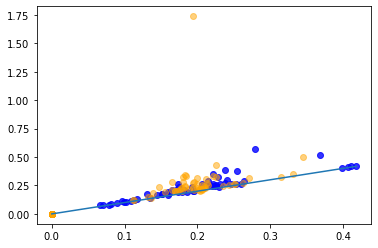

1/1 [==============================] - 7s 7s/step - loss: 1.2411
Epoch 38/50


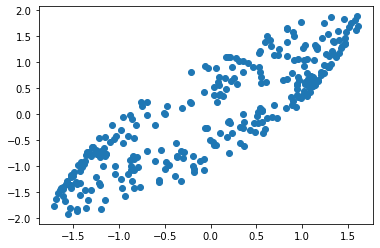

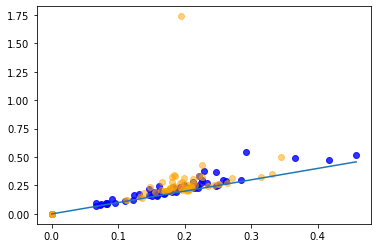

1/1 [==============================] - 8s 8s/step - loss: 1.2397
Epoch 39/50


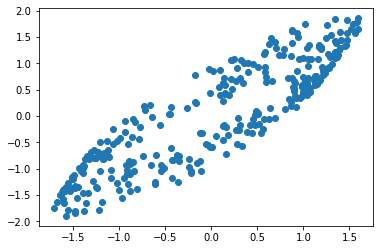

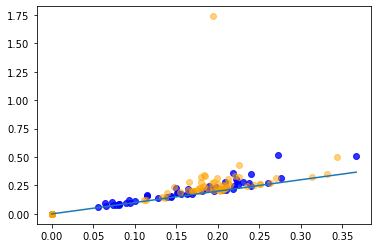

1/1 [==============================] - 7s 7s/step - loss: 1.2349
Epoch 40/50


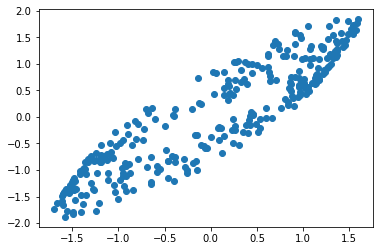

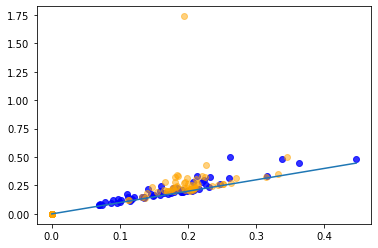

1/1 [==============================] - 7s 7s/step - loss: 1.2423
Epoch 41/50


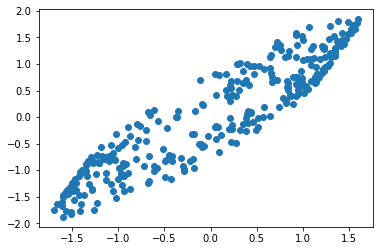

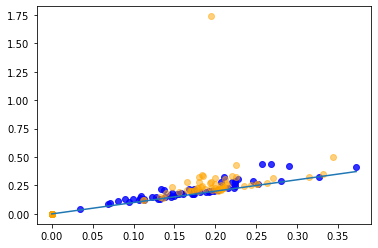

1/1 [==============================] - 7s 7s/step - loss: 1.2556
Epoch 42/50


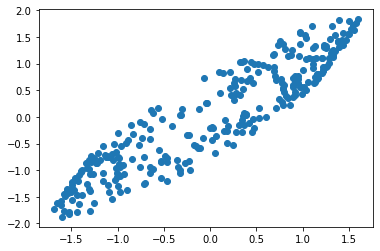

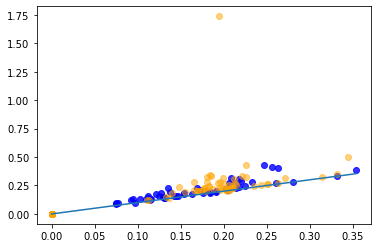

1/1 [==============================] - 7s 7s/step - loss: 1.2559
Epoch 43/50


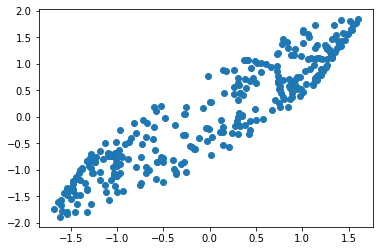

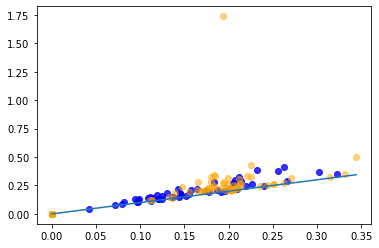

1/1 [==============================] - 7s 7s/step - loss: 1.2427
Epoch 44/50


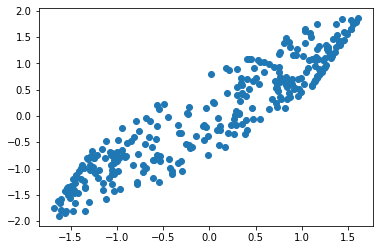

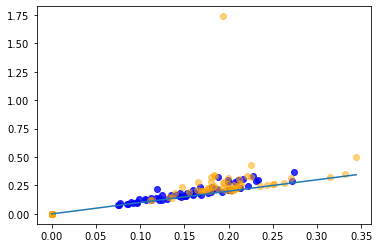

1/1 [==============================] - 8s 8s/step - loss: 1.2353
Epoch 45/50


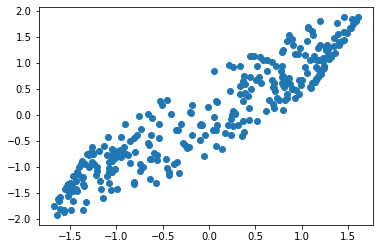

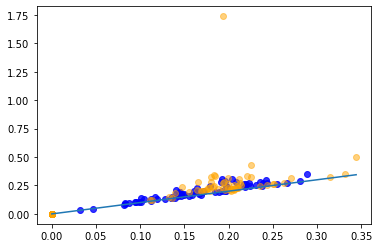

1/1 [==============================] - 7s 7s/step - loss: 1.2389
Epoch 46/50


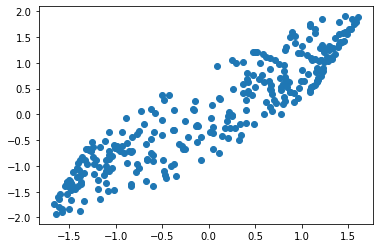

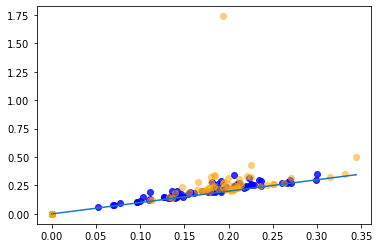

1/1 [==============================] - 7s 7s/step - loss: 1.2399
Epoch 47/50


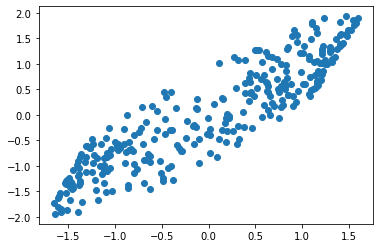

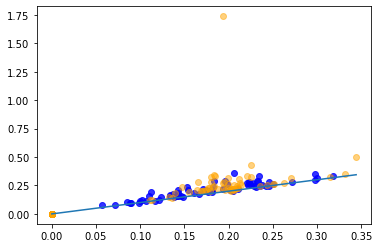

1/1 [==============================] - 7s 7s/step - loss: 1.2396
Epoch 48/50


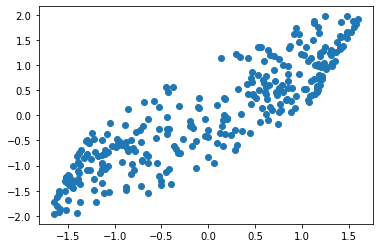

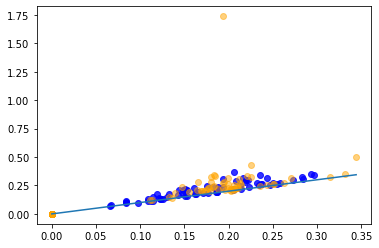

1/1 [==============================] - 7s 7s/step - loss: 1.2331
Epoch 49/50


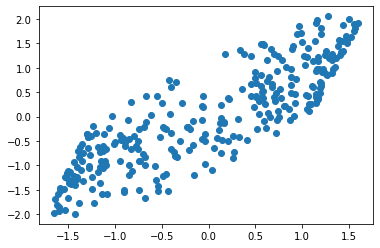

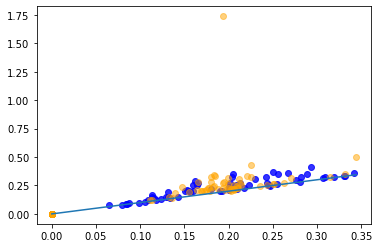

1/1 [==============================] - 7s 7s/step - loss: 1.2283
Epoch 50/50


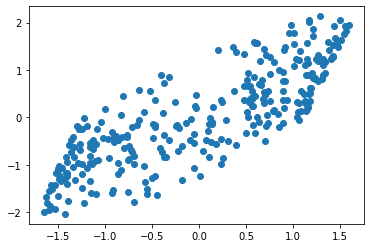

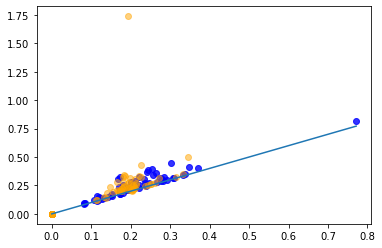

1/1 [==============================] - 7s 7s/step - loss: 1.2087


In [57]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=50,batch_size=n_samples)

### Relu Activation Function

Epoch 1/5


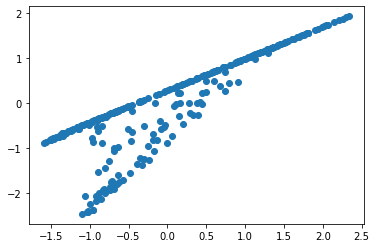

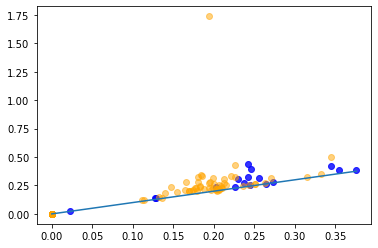

1/1 [==============================] - 7s 7s/step - loss: 1.2651
Epoch 2/5


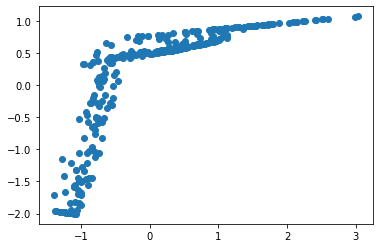

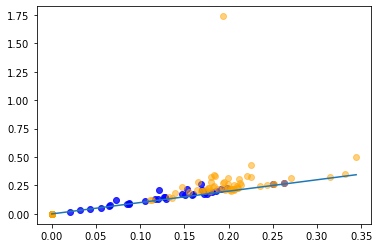

1/1 [==============================] - 7s 7s/step - loss: 1.3072
Epoch 3/5


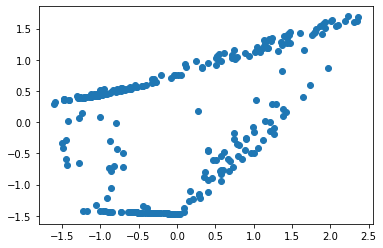

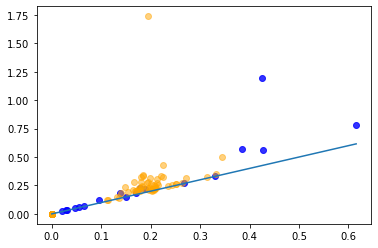

1/1 [==============================] - 7s 7s/step - loss: 0.4933
Epoch 4/5


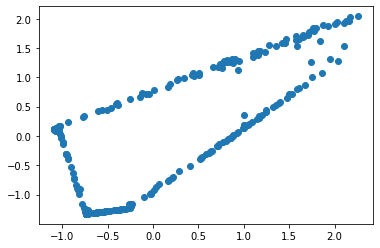

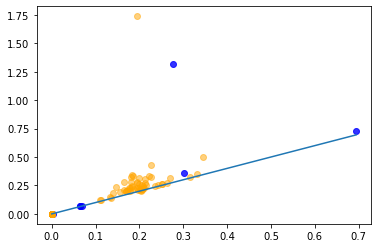

1/1 [==============================] - 7s 7s/step - loss: 0.3127
Epoch 5/5


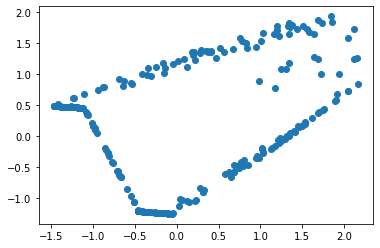

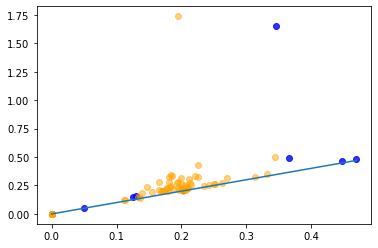

1/1 [==============================] - 7s 7s/step - loss: 0.1527


In [39]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

Epoch 1/15


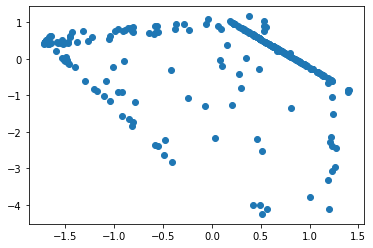

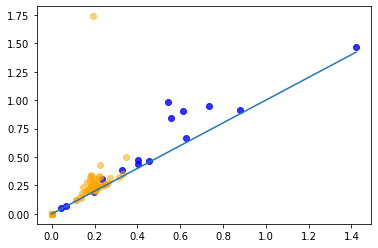

1/1 [==============================] - 8s 8s/step - loss: 0.9050
Epoch 2/15


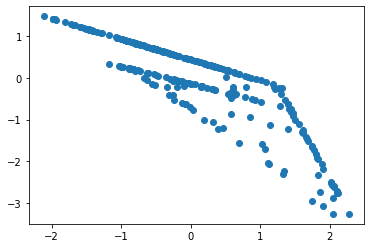

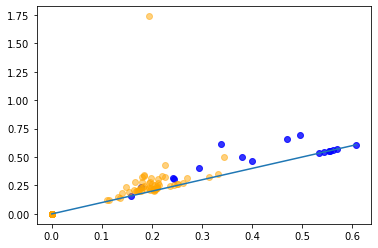

1/1 [==============================] - 7s 7s/step - loss: 1.2962
Epoch 3/15


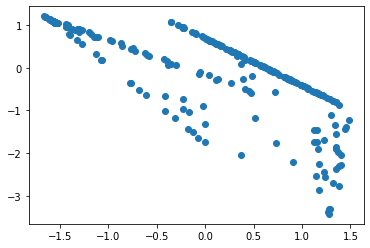

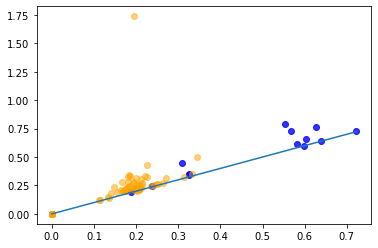

1/1 [==============================] - 8s 8s/step - loss: 1.1689
Epoch 4/15


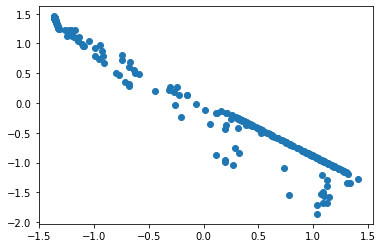

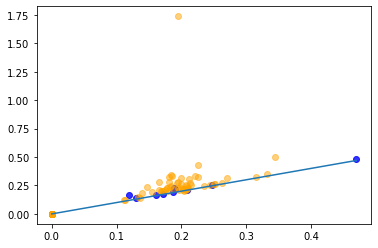

1/1 [==============================] - 7s 7s/step - loss: 1.3196
Epoch 5/15


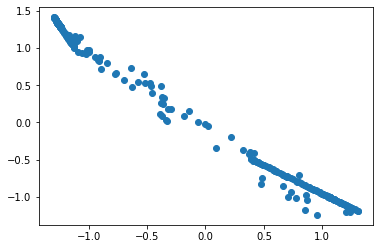

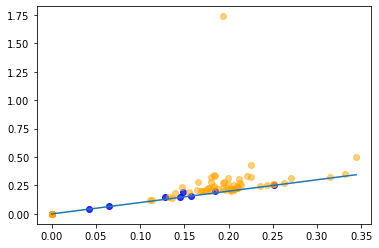

1/1 [==============================] - 7s 7s/step - loss: 1.3228
Epoch 6/15


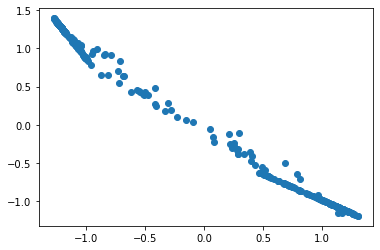

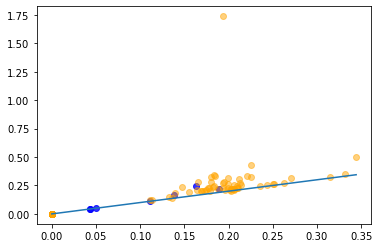

1/1 [==============================] - 7s 7s/step - loss: 1.3184
Epoch 7/15


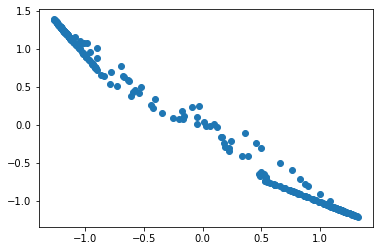

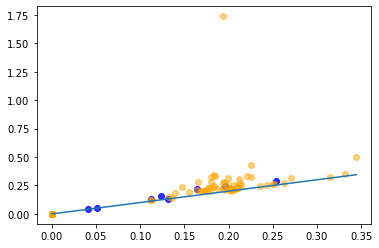

1/1 [==============================] - 7s 7s/step - loss: 1.3134
Epoch 8/15


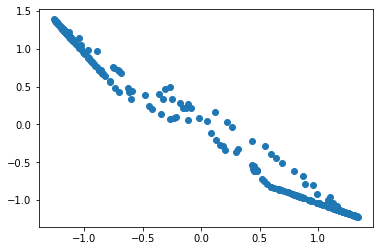

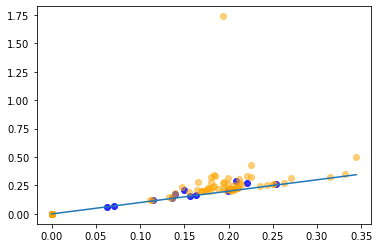

1/1 [==============================] - 7s 7s/step - loss: 1.3063
Epoch 9/15


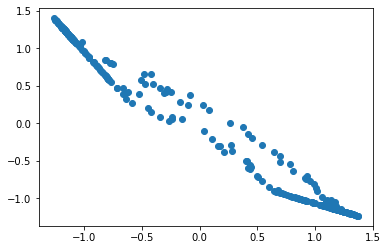

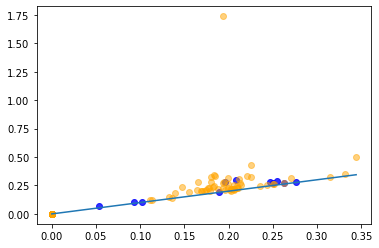

1/1 [==============================] - 7s 7s/step - loss: 1.2971
Epoch 10/15


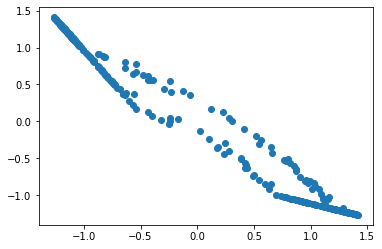

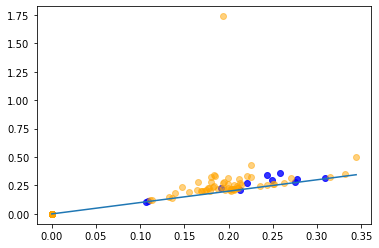

1/1 [==============================] - 7s 7s/step - loss: 1.2850
Epoch 11/15


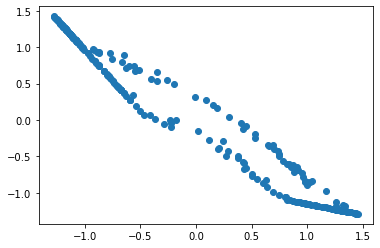

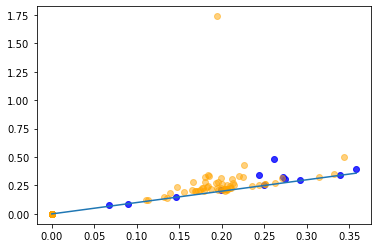

1/1 [==============================] - 7s 7s/step - loss: 1.2912
Epoch 12/15


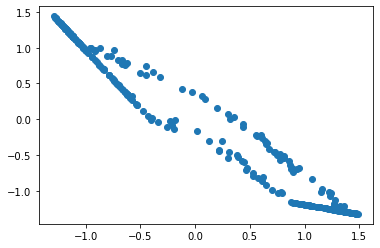

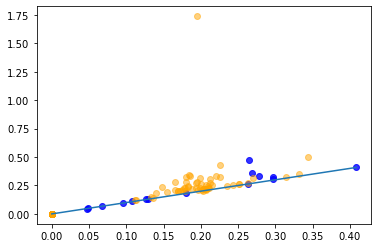

1/1 [==============================] - 7s 7s/step - loss: 1.2987
Epoch 13/15


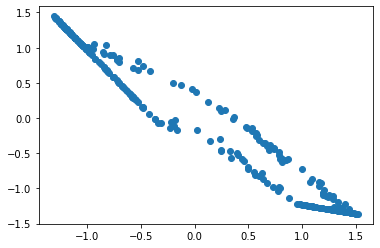

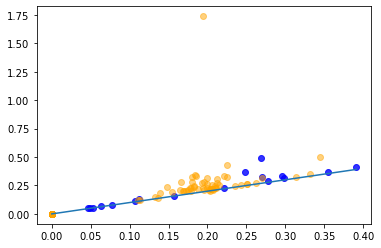

1/1 [==============================] - 7s 7s/step - loss: 1.2942
Epoch 14/15


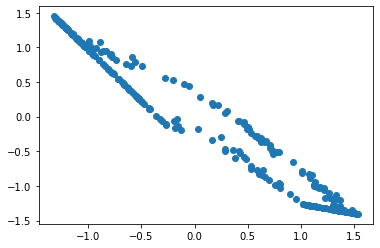

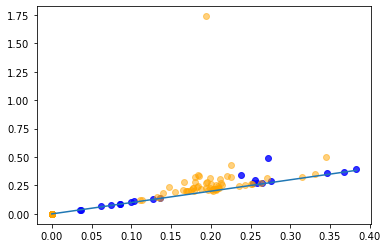

1/1 [==============================] - 7s 7s/step - loss: 1.2917
Epoch 15/15


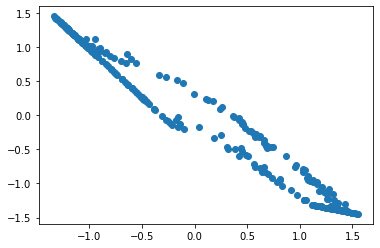

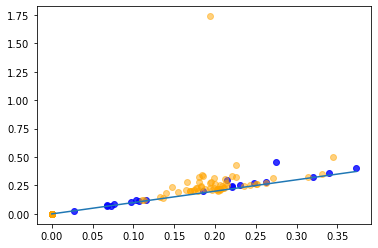

1/1 [==============================] - 8s 8s/step - loss: 1.2823


In [44]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=15,batch_size=n_samples)

Epoch 1/15


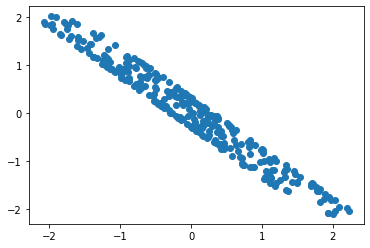

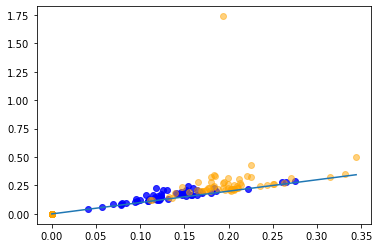

1/1 [==============================] - 8s 8s/step - loss: 1.3137
Epoch 2/15


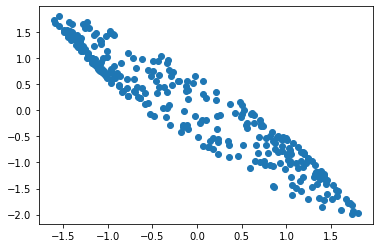

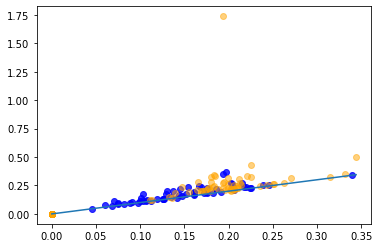

1/1 [==============================] - 8s 8s/step - loss: 1.2597
Epoch 3/15


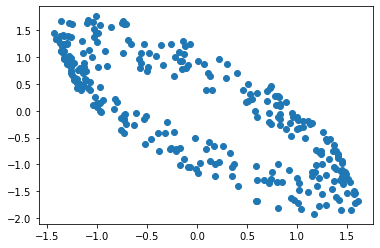

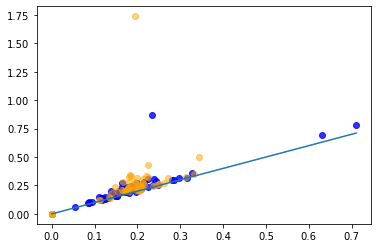

1/1 [==============================] - 8s 8s/step - loss: 0.8244
Epoch 4/15


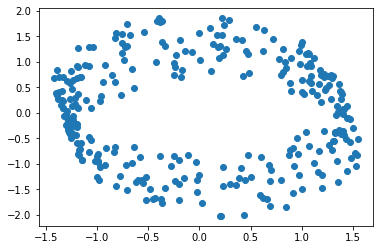

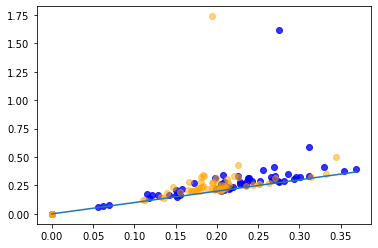

1/1 [==============================] - 8s 8s/step - loss: 0.0679
Epoch 5/15


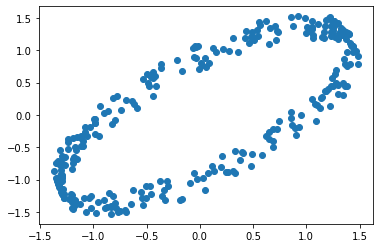

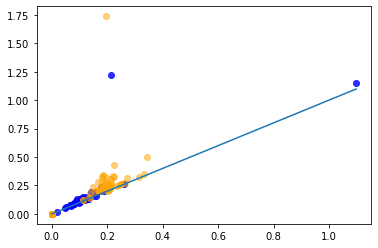

1/1 [==============================] - 7s 7s/step - loss: 0.3973
Epoch 6/15


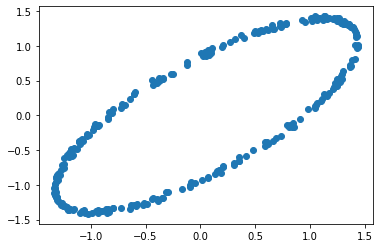

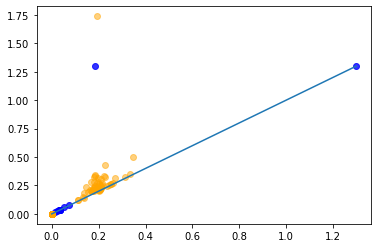

1/1 [==============================] - 7s 7s/step - loss: 0.3271
Epoch 7/15


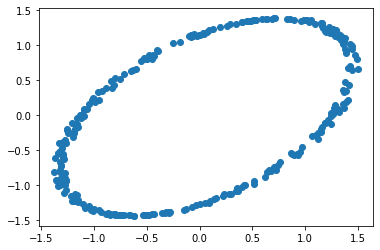

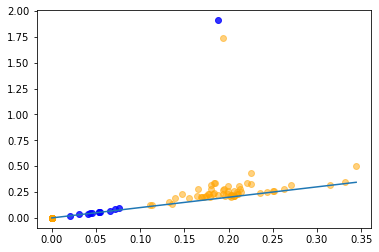

1/1 [==============================] - 7s 7s/step - loss: 0.1661
Epoch 8/15


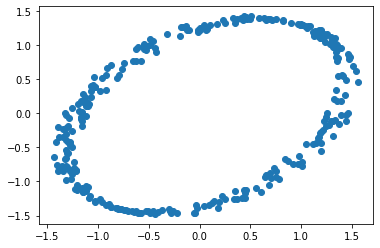

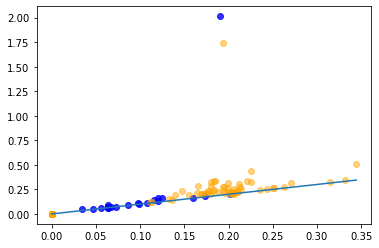

1/1 [==============================] - 7s 7s/step - loss: 0.2118
Epoch 9/15


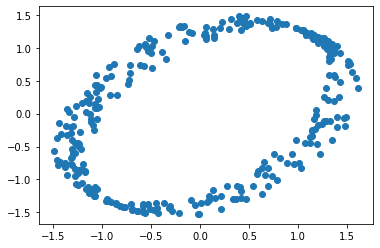

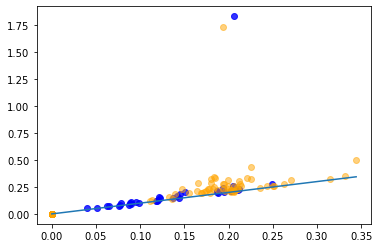

1/1 [==============================] - 7s 7s/step - loss: 0.1230
Epoch 10/15


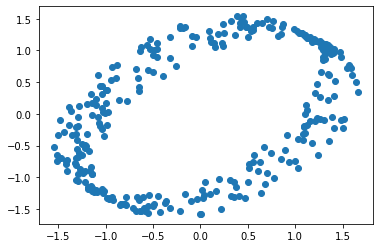

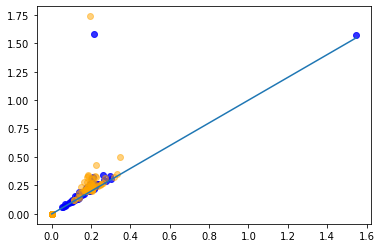

1/1 [==============================] - 7s 7s/step - loss: 0.0875
Epoch 11/15


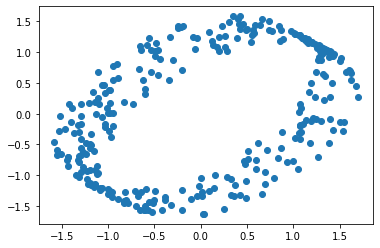

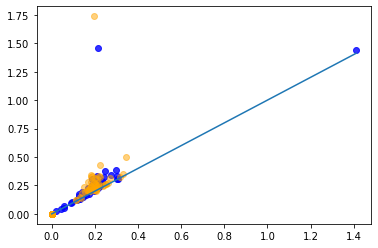

1/1 [==============================] - 8s 8s/step - loss: 0.1288
Epoch 12/15


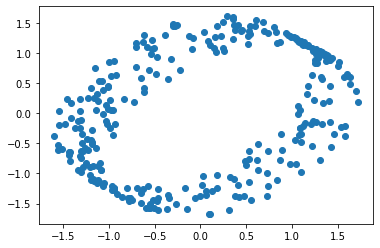

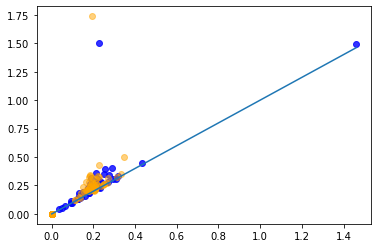

1/1 [==============================] - 7s 7s/step - loss: 0.1003
Epoch 13/15


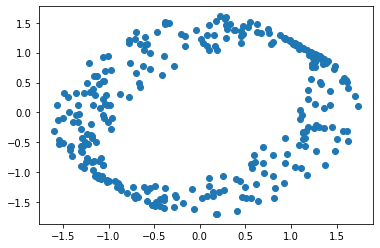

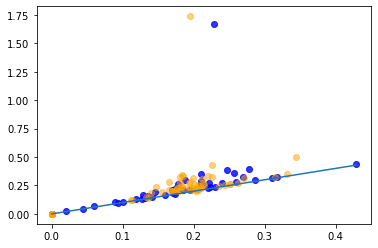

1/1 [==============================] - 8s 8s/step - loss: 0.0532
Epoch 14/15


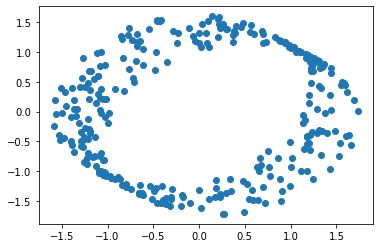

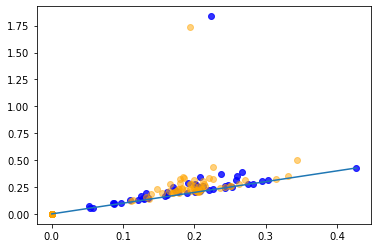

1/1 [==============================] - 8s 8s/step - loss: 0.0603
Epoch 15/15


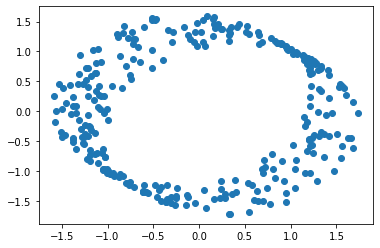

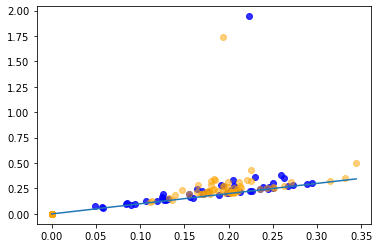

1/1 [==============================] - 8s 8s/step - loss: 0.0939


In [45]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=15,batch_size=n_samples)

In [ ]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=50,batch_size=n_samples)

Epoch 1/50


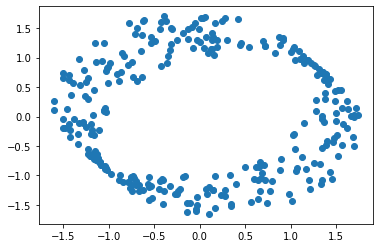

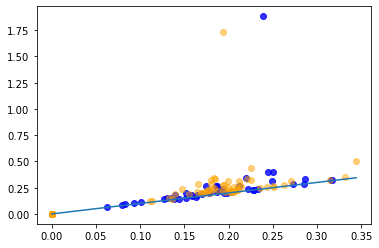

1/1 [==============================] - 7s 7s/step - loss: 0.0772
Epoch 2/50


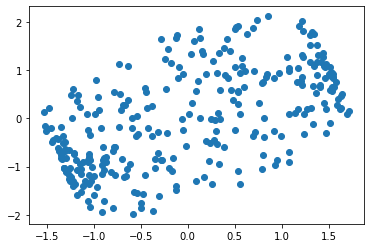

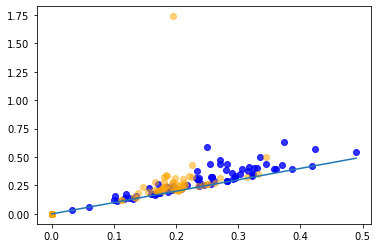

1/1 [==============================] - 7s 7s/step - loss: 1.3763
Epoch 3/50


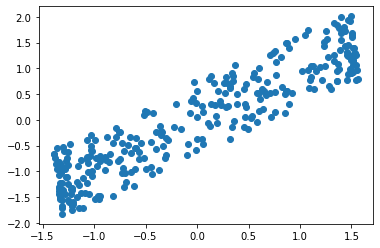

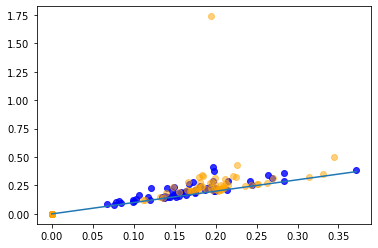

1/1 [==============================] - 7s 7s/step - loss: 1.2420
Epoch 4/50


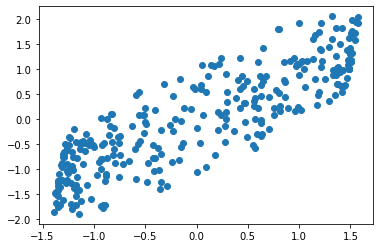

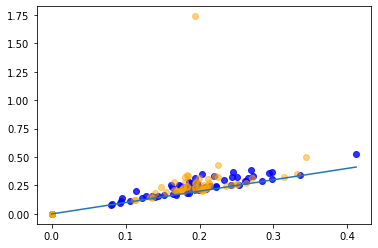

1/1 [==============================] - 8s 8s/step - loss: 1.2212
Epoch 5/50


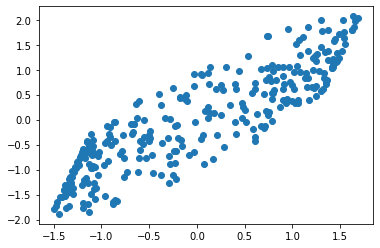

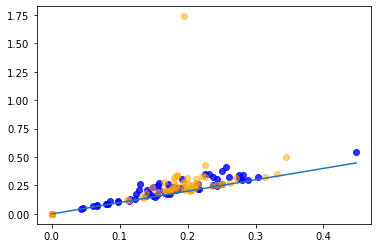

1/1 [==============================] - 7s 7s/step - loss: 1.2347
Epoch 6/50


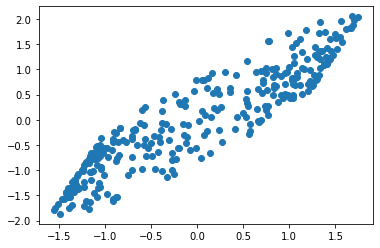

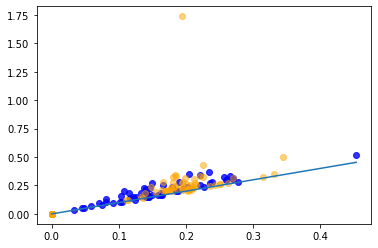

1/1 [==============================] - 7s 7s/step - loss: 1.2428
Epoch 7/50


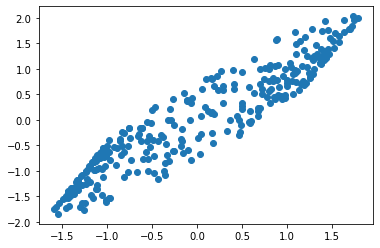

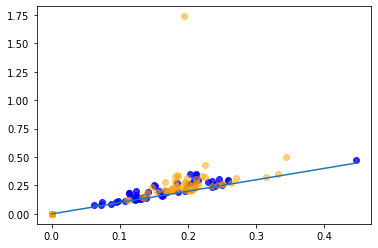

1/1 [==============================] - 8s 8s/step - loss: 1.2364
Epoch 8/50


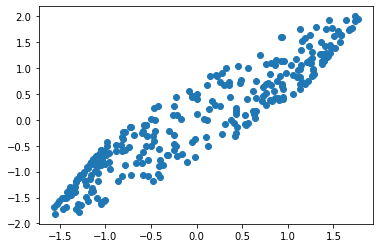

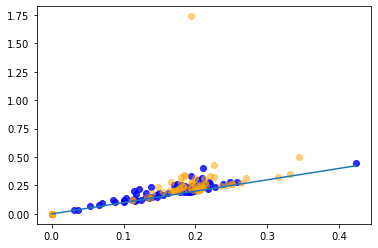

1/1 [==============================] - 8s 8s/step - loss: 1.2302
Epoch 9/50


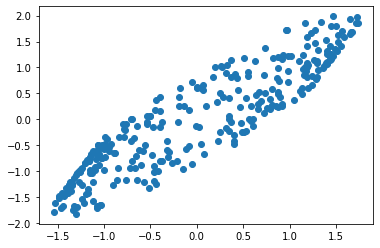

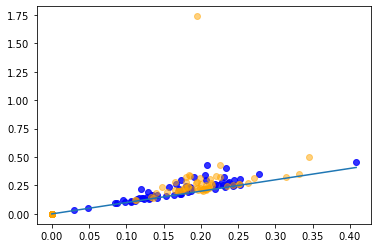

1/1 [==============================] - 8s 8s/step - loss: 1.2214
Epoch 10/50


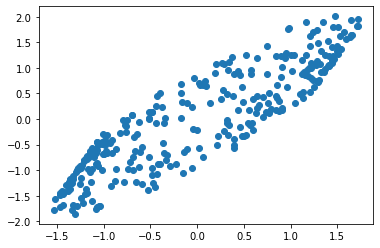

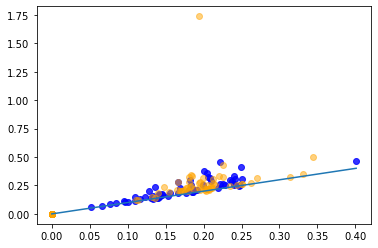

1/1 [==============================] - 8s 8s/step - loss: 1.2219
Epoch 11/50


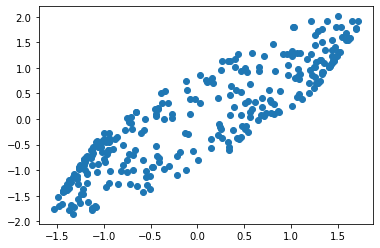

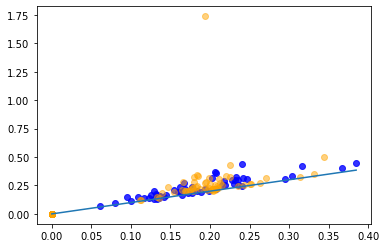

1/1 [==============================] - 7s 7s/step - loss: 1.2243
Epoch 12/50


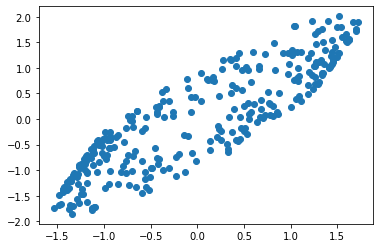

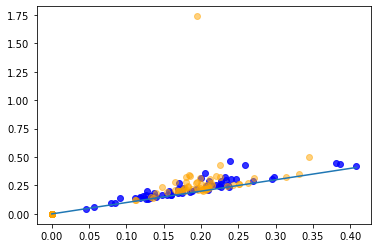

1/1 [==============================] - 7s 7s/step - loss: 1.2311
Epoch 13/50


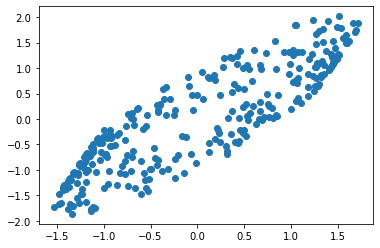

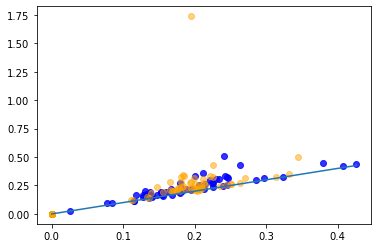

1/1 [==============================] - 7s 7s/step - loss: 1.2291
Epoch 14/50


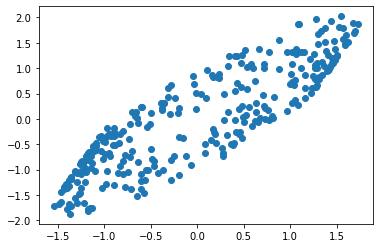

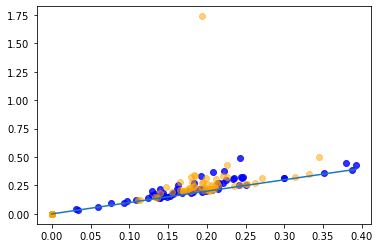

1/1 [==============================] - 7s 7s/step - loss: 1.2217
Epoch 15/50


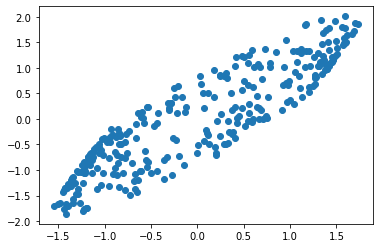

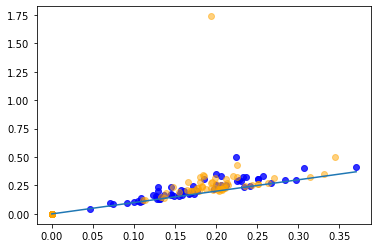

1/1 [==============================] - 7s 7s/step - loss: 1.2292
Epoch 16/50


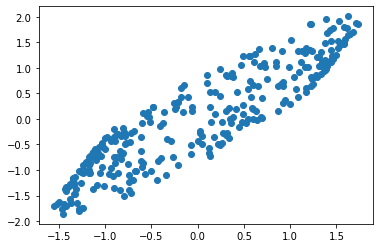

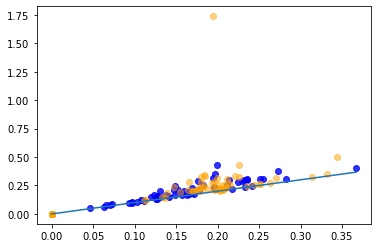

1/1 [==============================] - 7s 7s/step - loss: 1.2274
Epoch 17/50


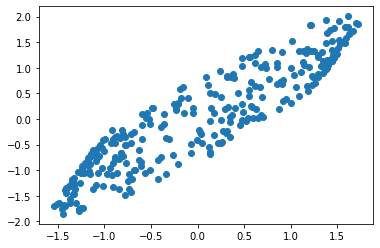

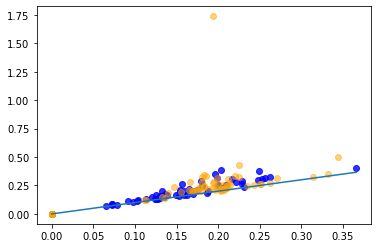

1/1 [==============================] - 8s 8s/step - loss: 1.2281
Epoch 18/50


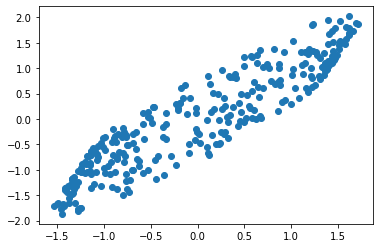

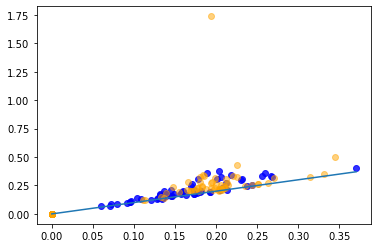

1/1 [==============================] - 8s 8s/step - loss: 1.2329
Epoch 19/50


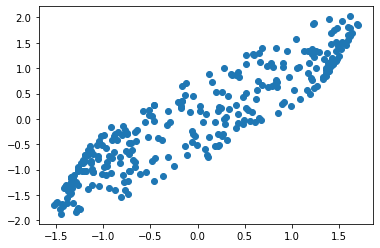

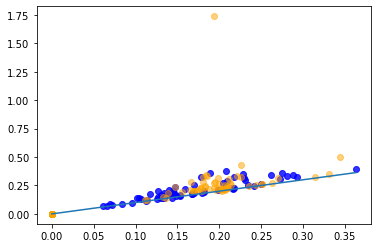

1/1 [==============================] - 7s 7s/step - loss: 1.2412
Epoch 20/50


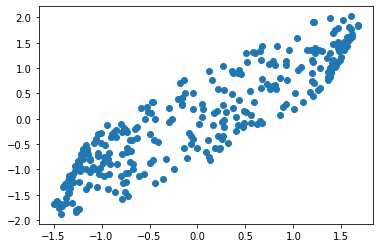

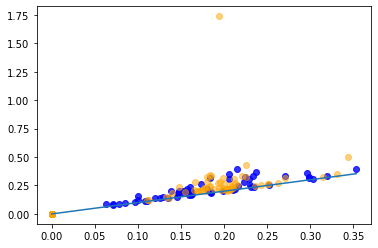

1/1 [==============================] - 8s 8s/step - loss: 1.2332
Epoch 21/50


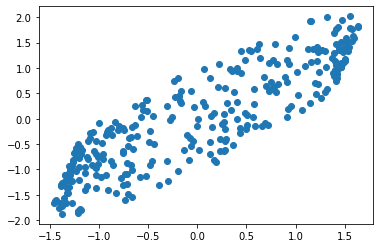

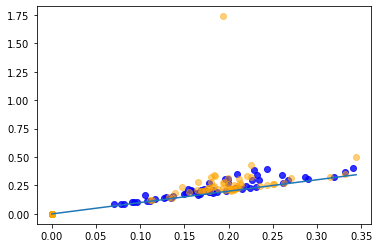

1/1 [==============================] - 8s 8s/step - loss: 1.2299
Epoch 22/50


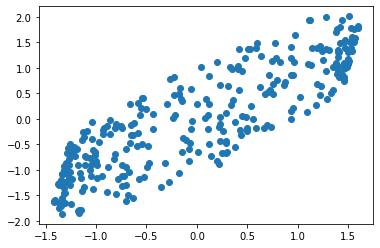

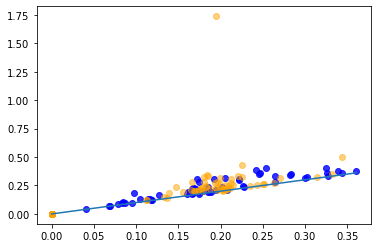

1/1 [==============================] - 7s 7s/step - loss: 1.2356
Epoch 23/50


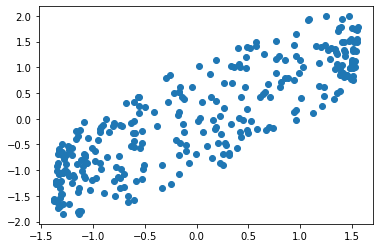

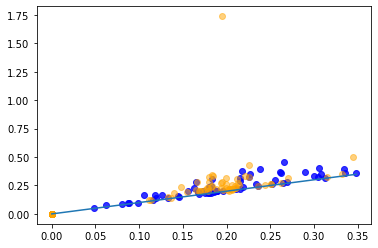

1/1 [==============================] - 7s 7s/step - loss: 1.2379
Epoch 24/50


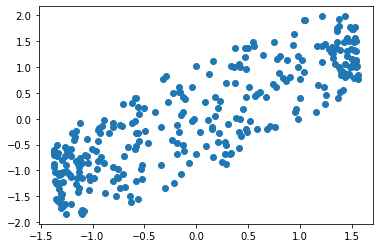

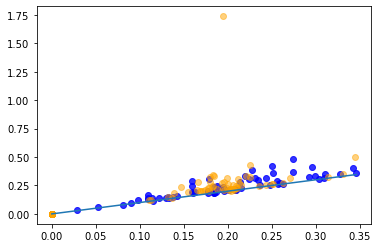

1/1 [==============================] - 7s 7s/step - loss: 1.2345
Epoch 25/50


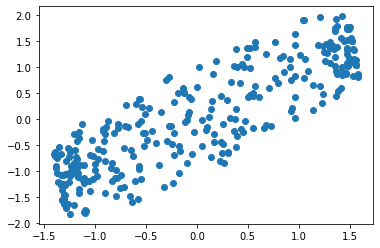

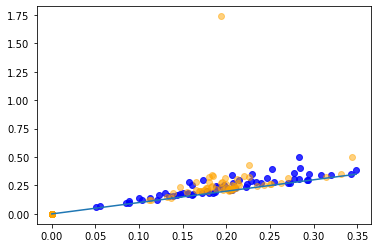

1/1 [==============================] - 7s 7s/step - loss: 1.2283
Epoch 26/50


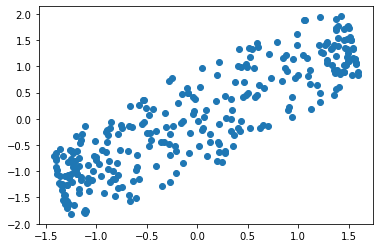

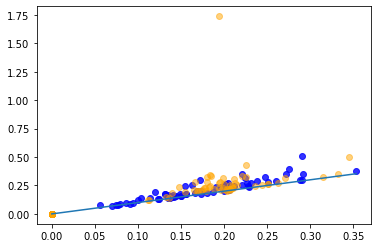

1/1 [==============================] - 8s 8s/step - loss: 1.2248
Epoch 27/50


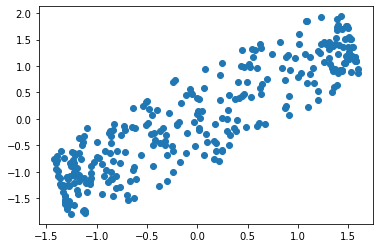

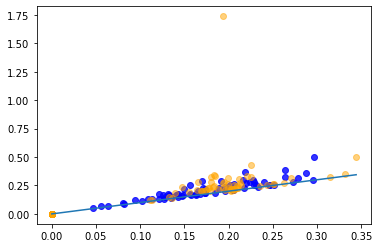

1/1 [==============================] - 7s 7s/step - loss: 1.2247
Epoch 28/50


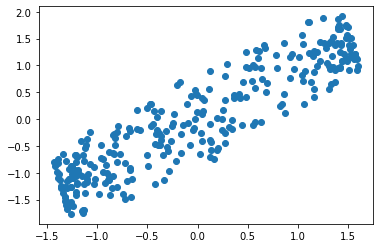

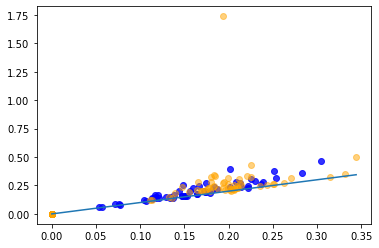

1/1 [==============================] - 8s 8s/step - loss: 1.2298
Epoch 29/50


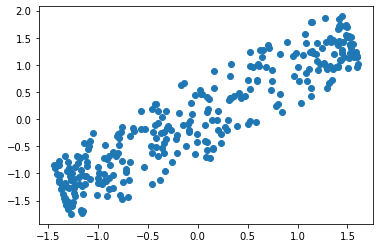

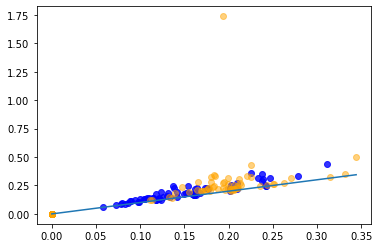

1/1 [==============================] - 7s 7s/step - loss: 1.2453
Epoch 30/50


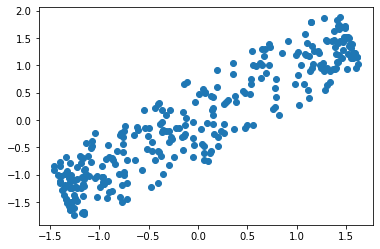

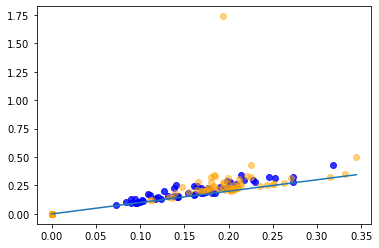

1/1 [==============================] - 7s 7s/step - loss: 1.2380
Epoch 31/50


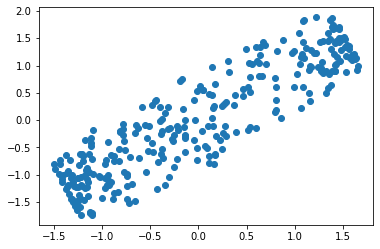

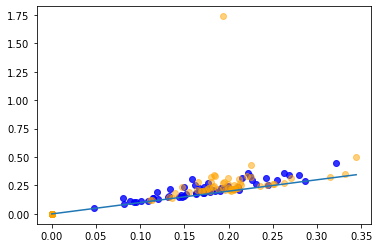

1/1 [==============================] - 7s 7s/step - loss: 1.2249
Epoch 32/50


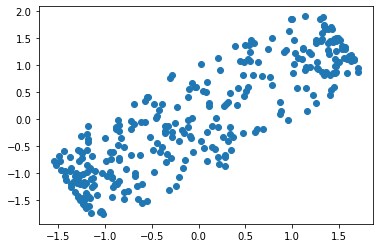

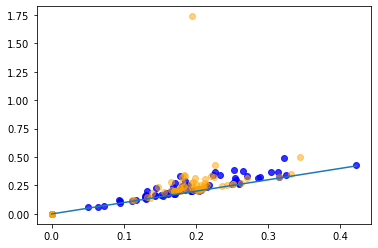

1/1 [==============================] - 7s 7s/step - loss: 1.2247
Epoch 33/50


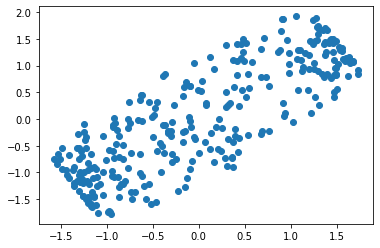

KeyboardInterrupt: 

In [46]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=50,batch_size=n_samples)

### Layers

1 Hidden Layer

Epoch 1/5


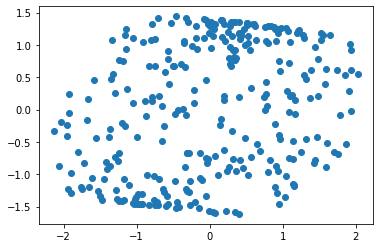

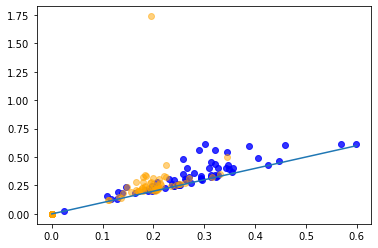

1/1 [==============================] - 7s 7s/step - loss: 1.4117
Epoch 2/5


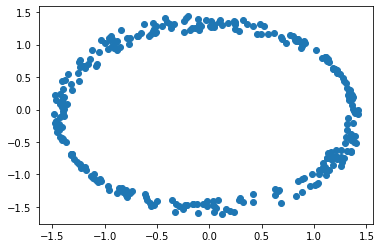

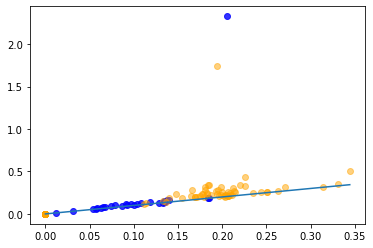

1/1 [==============================] - 8s 8s/step - loss: 0.4868
Epoch 3/5


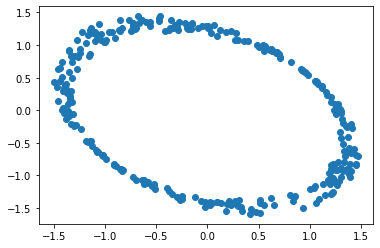

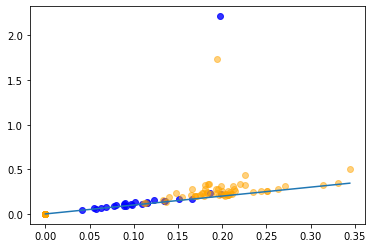

1/1 [==============================] - 8s 8s/step - loss: 0.3597
Epoch 4/5


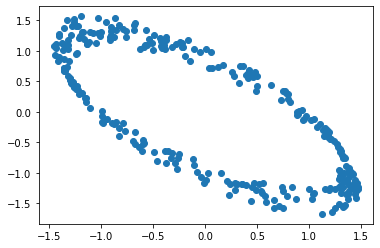

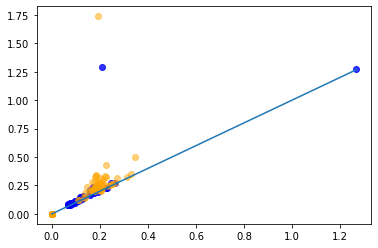

1/1 [==============================] - 8s 8s/step - loss: 0.3191
Epoch 5/5


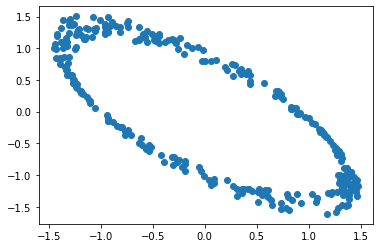

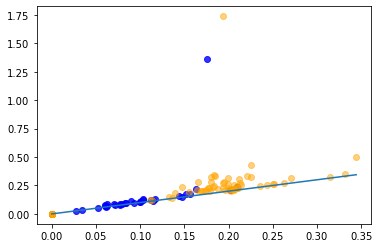

1/1 [==============================] - 8s 8s/step - loss: 0.2679


In [52]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

Epoch 1/10


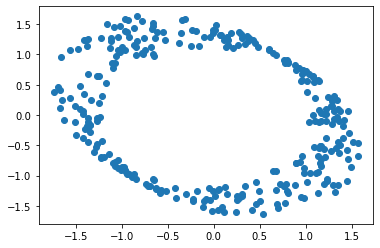

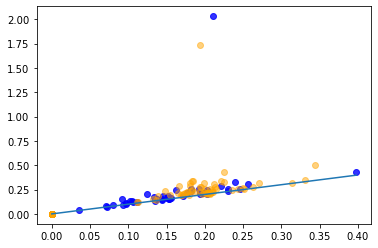

1/1 [==============================] - 7s 7s/step - loss: 0.1634
Epoch 2/10


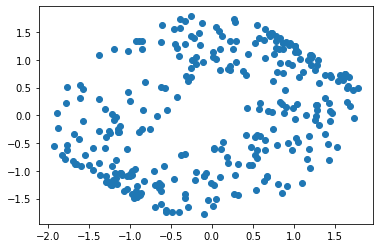

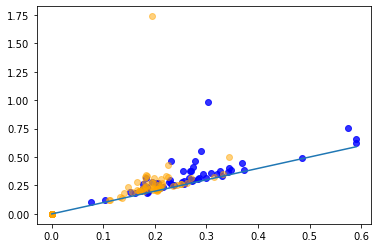

1/1 [==============================] - 7s 7s/step - loss: 0.6797
Epoch 3/10


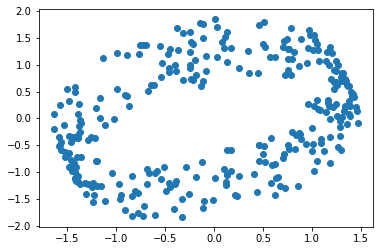

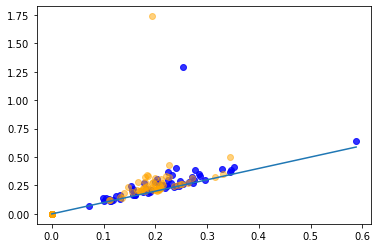

1/1 [==============================] - 7s 7s/step - loss: 0.2469
Epoch 4/10


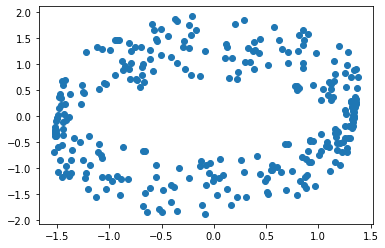

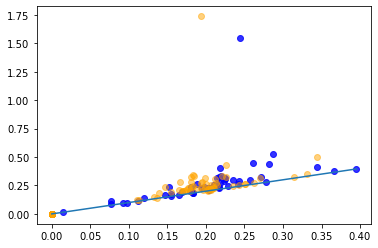

1/1 [==============================] - 8s 8s/step - loss: 0.0801
Epoch 5/10


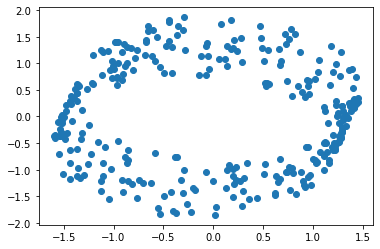

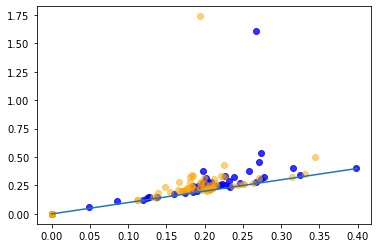

1/1 [==============================] - 8s 8s/step - loss: 0.0556
Epoch 6/10


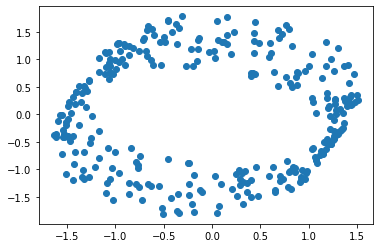

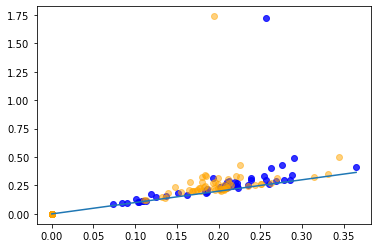

1/1 [==============================] - 8s 8s/step - loss: 0.0461
Epoch 7/10


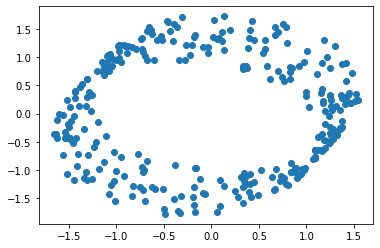

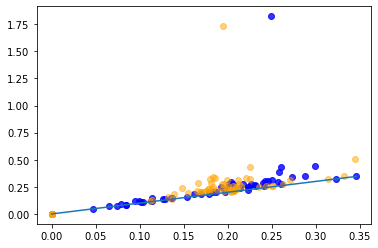

1/1 [==============================] - 8s 8s/step - loss: 0.0560
Epoch 8/10


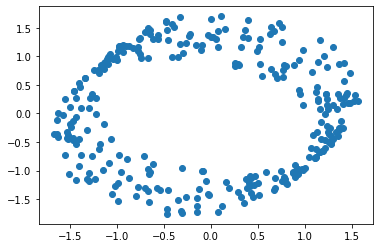

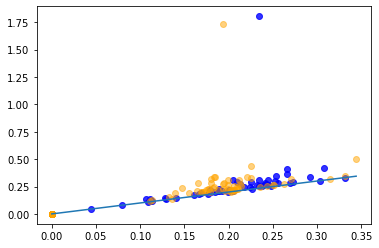

1/1 [==============================] - 8s 8s/step - loss: 0.0529
Epoch 9/10


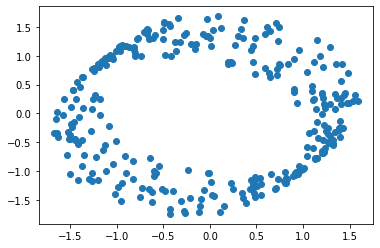

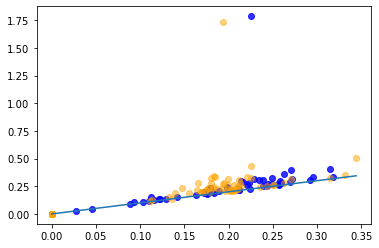

1/1 [==============================] - 8s 8s/step - loss: 0.0529
Epoch 10/10


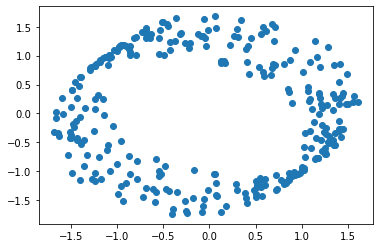

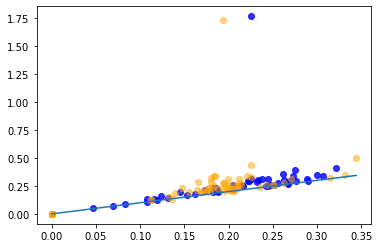

1/1 [==============================] - 8s 8s/step - loss: 0.0526


In [53]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=10,batch_size=n_samples)

3 Hidden Layers

Epoch 1/5


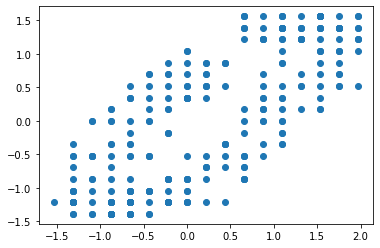

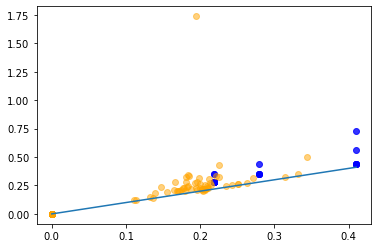

1/1 [==============================] - 7s 7s/step - loss: 1.1874
Epoch 2/5


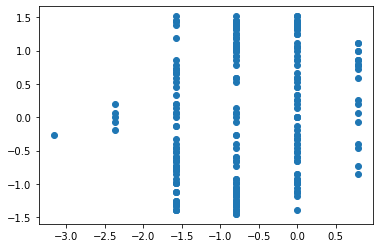

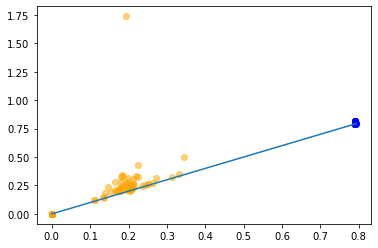

1/1 [==============================] - 8s 8s/step - loss: 1.3284
Epoch 3/5


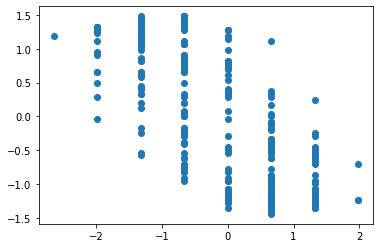

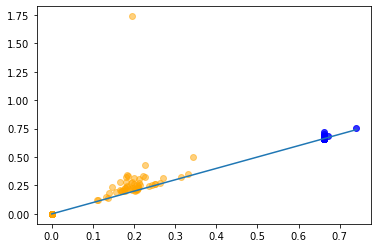

1/1 [==============================] - 7s 7s/step - loss: 1.3307
Epoch 4/5


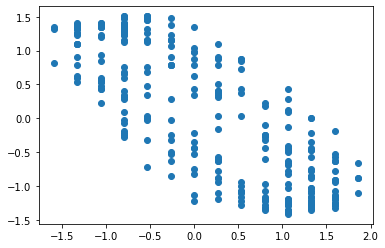

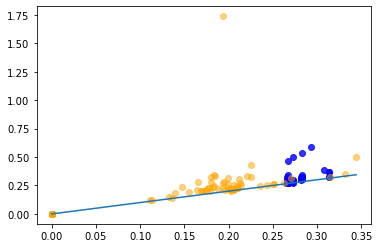

1/1 [==============================] - 8s 8s/step - loss: 1.3438
Epoch 5/5


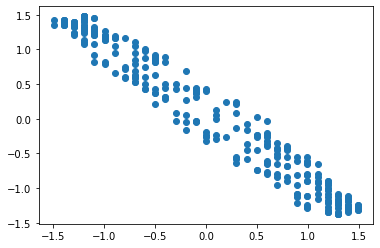

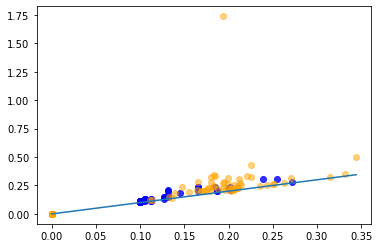

1/1 [==============================] - 7s 7s/step - loss: 1.2946


In [47]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

Looks Good!

Epoch 1/10


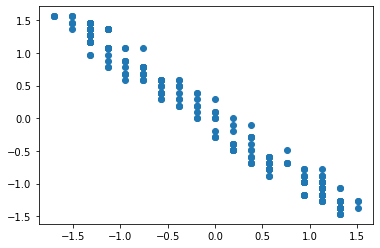

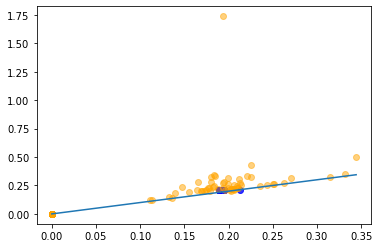

1/1 [==============================] - 7s 7s/step - loss: 1.3177
Epoch 2/10


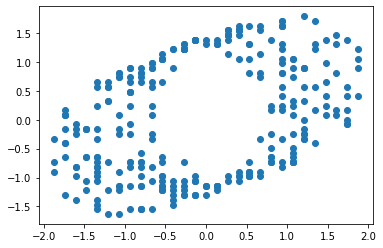

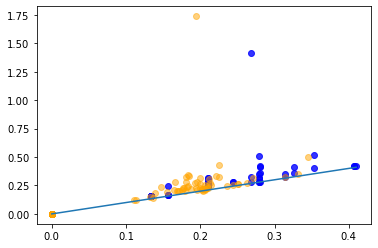

1/1 [==============================] - 8s 8s/step - loss: 0.1835
Epoch 3/10


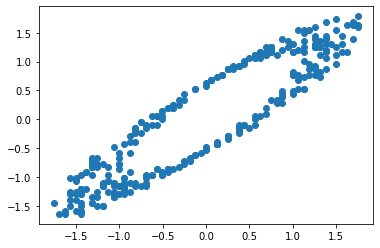

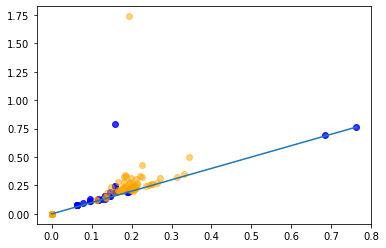

1/1 [==============================] - 8s 8s/step - loss: 1.0194
Epoch 4/10


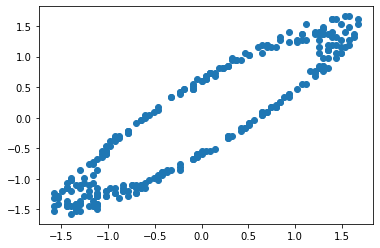

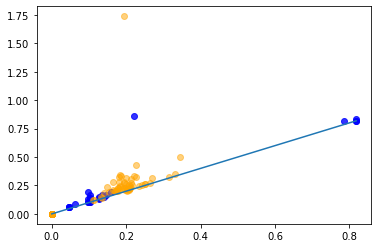

1/1 [==============================] - 8s 8s/step - loss: 0.9130
Epoch 5/10


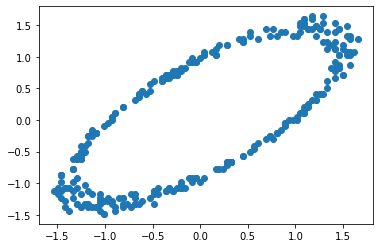

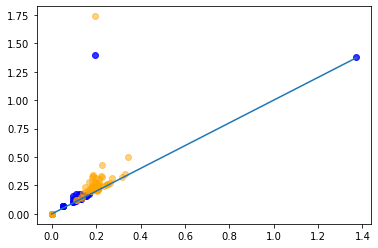

1/1 [==============================] - 7s 7s/step - loss: 0.2548
Epoch 6/10


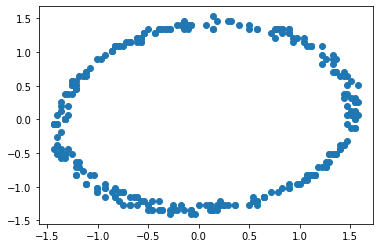

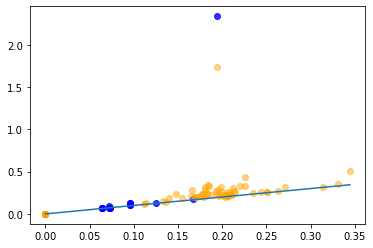

1/1 [==============================] - 8s 8s/step - loss: 0.4968
Epoch 7/10


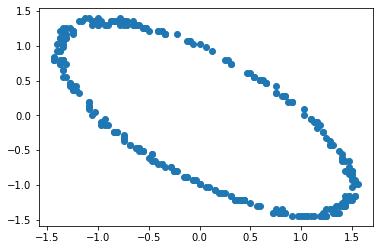

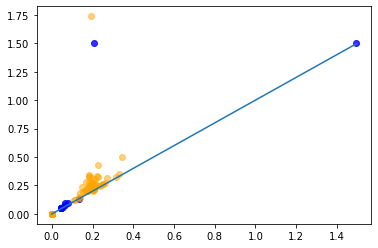

1/1 [==============================] - 7s 7s/step - loss: 0.1906
Epoch 8/10


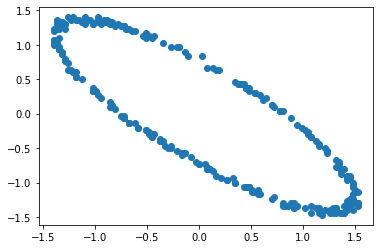

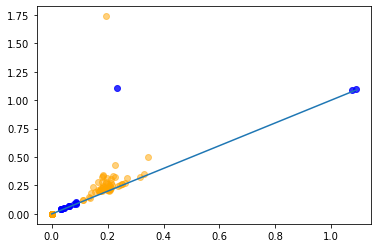

1/1 [==============================] - 7s 7s/step - loss: 0.5345
Epoch 9/10


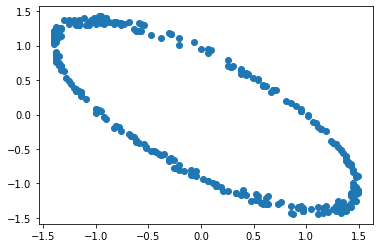

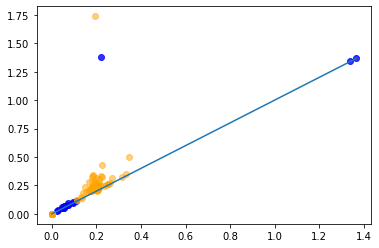

1/1 [==============================] - 8s 8s/step - loss: 0.2632
Epoch 10/10


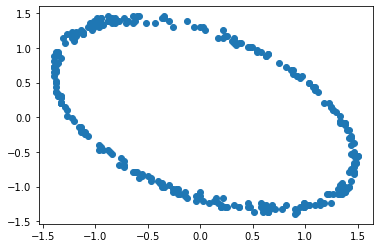

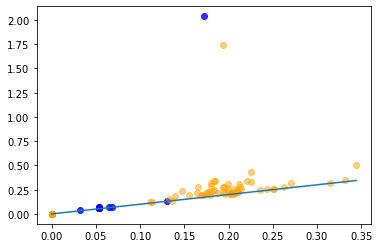

1/1 [==============================] - 7s 7s/step - loss: 0.2274


In [49]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=10,batch_size=n_samples)

### 4 Hidden Layers

TERRIBLE?!?!?!

Epoch 1/5


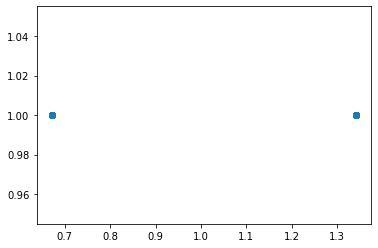

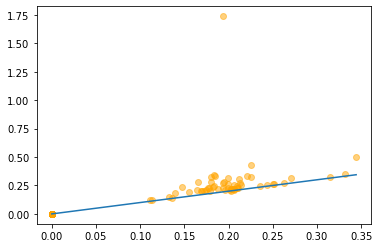

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 2/5


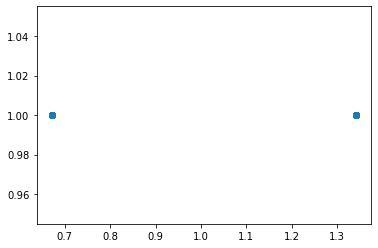

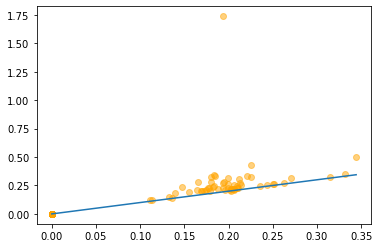

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 3/5


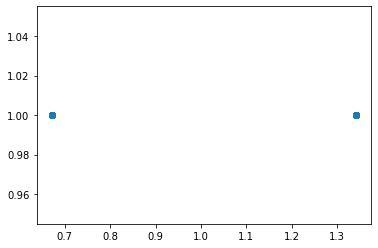

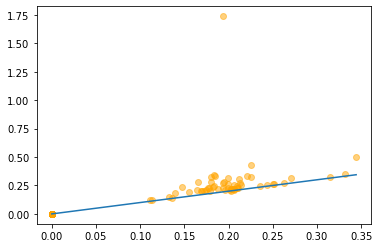

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 4/5


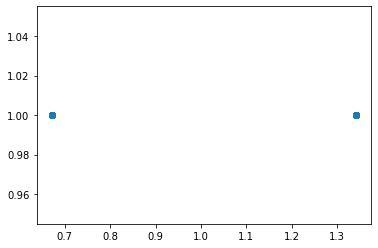

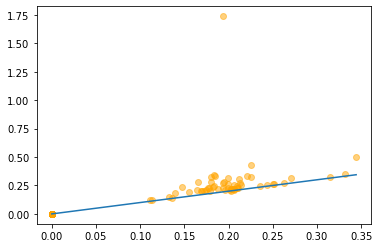

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 5/5


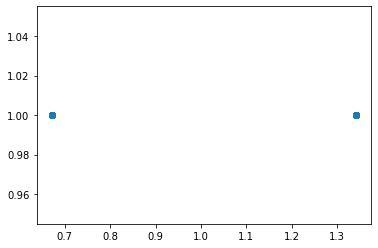

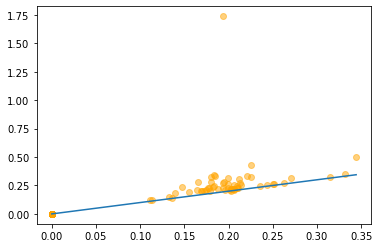

1/1 [==============================] - 7s 7s/step - loss: 1.3262


In [50]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

Epoch 1/5


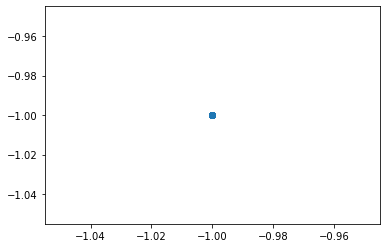

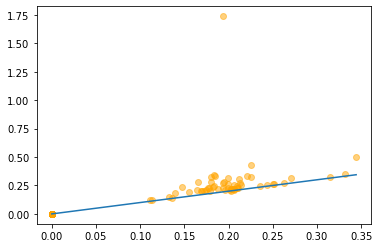

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 2/5


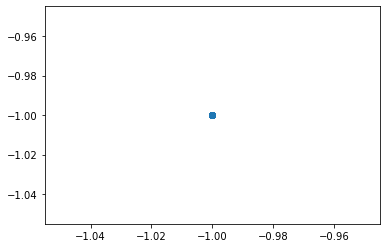

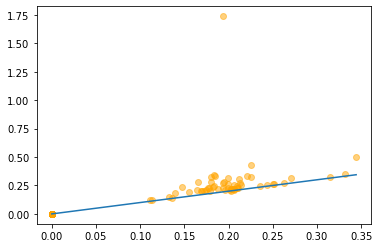

1/1 [==============================] - 8s 8s/step - loss: 1.3262
Epoch 3/5


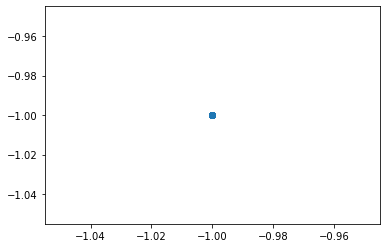

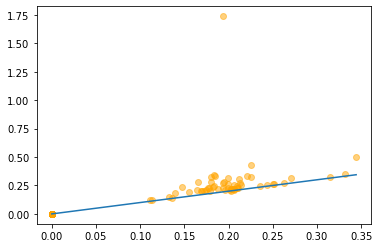

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 4/5


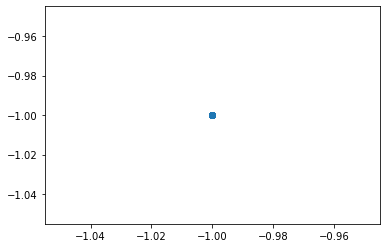

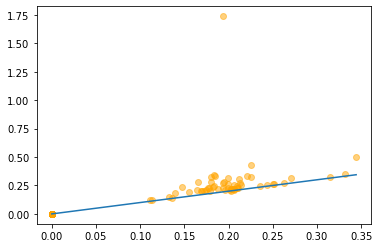

1/1 [==============================] - 7s 7s/step - loss: 1.3262
Epoch 5/5


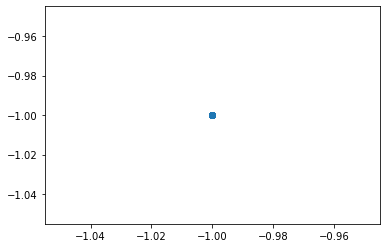

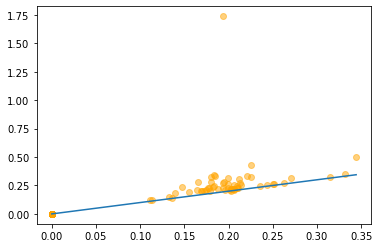

1/1 [==============================] - 8s 8s/step - loss: 1.3262


In [51]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

# 2 Cylinder

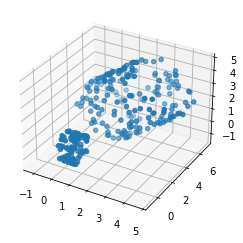

In [15]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back

ss3=np.random.uniform(0,2*np.pi,100)
noise=np.random.normal(0,0.1,150) #add noise if you want

#small cylinder
noise=0 #cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)




rr3=np.random.uniform(0,1,100) 

np.random.seed(100)
sss3=np.random.uniform(0,2*np.pi,200)
xxx=3+2*np.cos(sss3)
yyy=2*np.sin(sss3)


xxx45=2+xxx #how far apart the cylinders are 


rrr3=np.random.uniform(0,5,200) 

#rotate by 45 degree
rrr45=rrr3*np.sqrt(2)/2-np.sqrt(2)/2*yyy
yyy45=rrr3*np.sqrt(2)/2+np.sqrt(2)/2*yyy


#np.r_ concatenate 
RR=np.r_[rr3,rrr45]  #points on one axis
RX=np.r_[xx,xxx] #not used
RY=np.r_[yy,yyy] #not used

RX45=np.r_[xx,xxx45] #points on one axis
RY45=np.r_[yy,yyy45] #points on one axis

ax = plt.subplot(111, projection='3d')
X=np.array(np.mat([RR,RX45,RY45]).T,dtype=np.float32)
ax.scatter(X[:,0],X[:,1],X[:,2]) 
plt.show()

In [16]:
X.shape

(300, 3)

Epoch 1/10


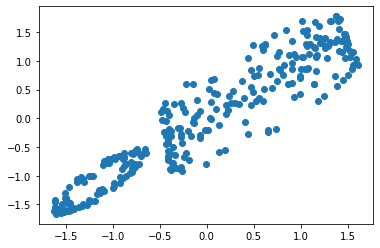

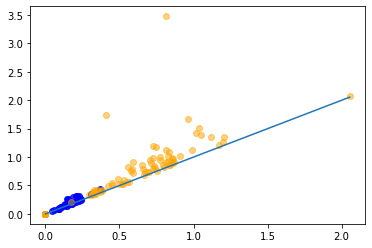

1/1 [==============================] - 6s 6s/step - loss: 5.6924
Epoch 2/10


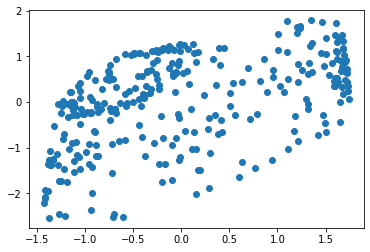

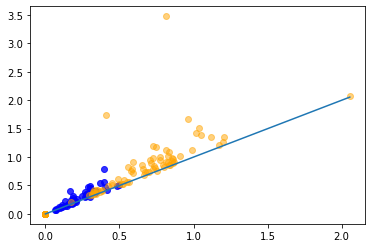

1/1 [==============================] - 7s 7s/step - loss: 5.7232
Epoch 3/10


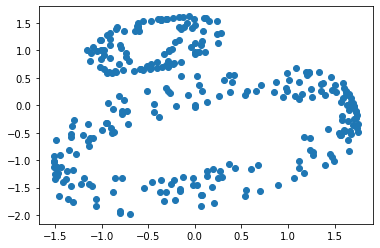

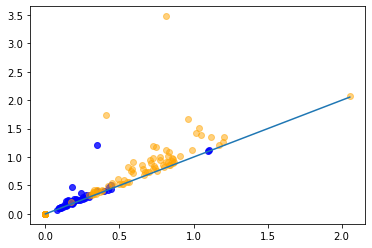

1/1 [==============================] - 7s 7s/step - loss: 5.0856
Epoch 4/10


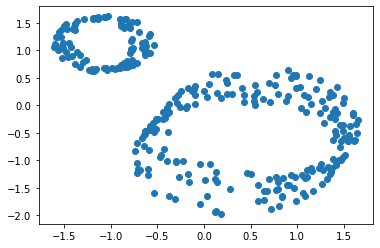

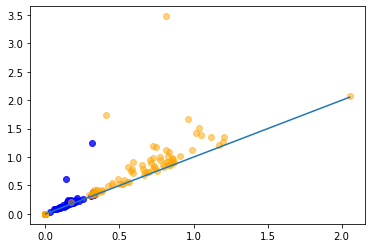

1/1 [==============================] - 7s 7s/step - loss: 5.1099
Epoch 5/10


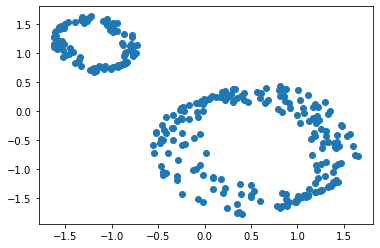

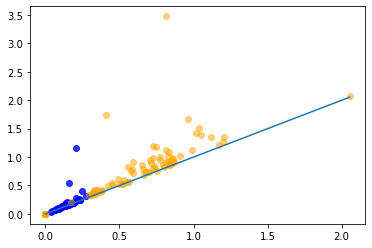

1/1 [==============================] - 7s 7s/step - loss: 5.2089
Epoch 6/10


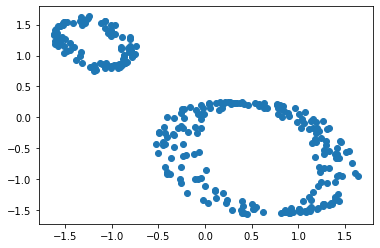

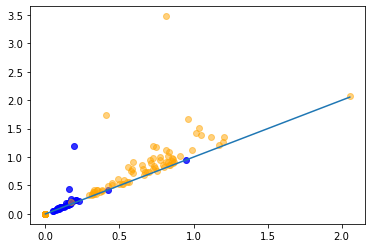

1/1 [==============================] - 7s 7s/step - loss: 5.1449
Epoch 7/10


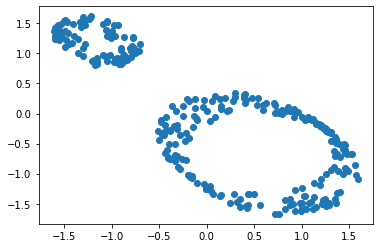

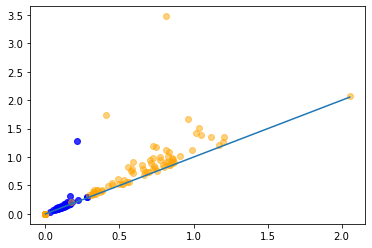

1/1 [==============================] - 7s 7s/step - loss: 5.0325
Epoch 8/10


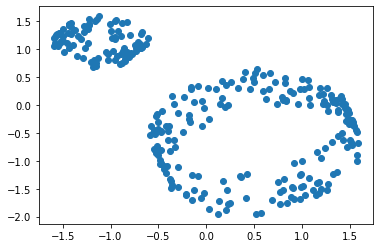

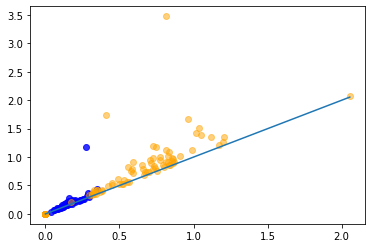

1/1 [==============================] - 7s 7s/step - loss: 5.1237
Epoch 9/10


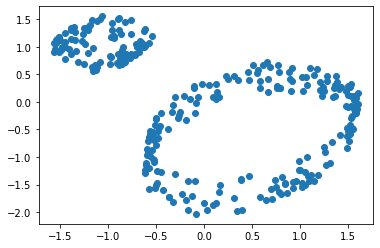

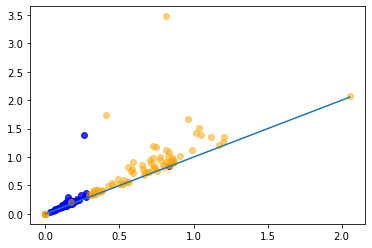

1/1 [==============================] - 7s 7s/step - loss: 4.9337
Epoch 10/10


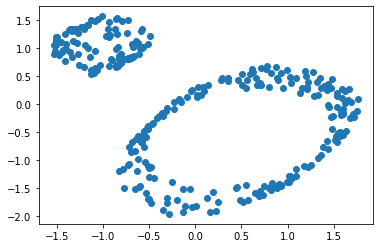

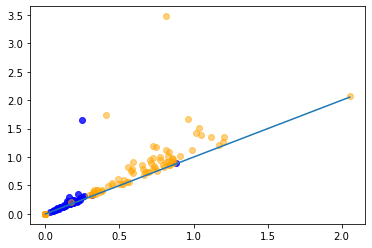

1/1 [==============================] - 7s 7s/step - loss: 4.8243


In [25]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=10,batch_size=n_samples)

# Swiss Roll with hole

In [12]:
from sklearn.utils import check_random_state

In [13]:
def make_swiss_roll_with_hole(n_samples=100, noise=0.0, random_state=None):
    # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/datasets/_samples_generator.py#L1401
    generator = check_random_state(random_state)
    t = 1.5 * np.pi * (1 + 2 * generator.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * generator.rand(1, n_samples)
    z = t * np.sin(t)

    X = np.concatenate((x, y, z))

    # ranges of three coordinates:
    # np.max(X[2,:]) = 14.136094274051034
    # np.min(X[2,:]) = -11.040707948365629
    # np.max(X[1,:]) = 20.996180119068676
    # np.min(X[1,:]) = 0.004955591716158225
    # np.max(X[0,:]) = 12.60593128332993
    # np.min(X[0,:]) = -9.47727415039662

    # mask = ((X[0, :]>-8) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    # mask = ((X[0, :]>-10) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    mask = ((X[0, :]>-10) & (X[0, :]<-5) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    X[:, mask] = None
    
    X += noise * generator.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)

    # remove the nan values (related to hole):
    hole_point_indices_3D = np.isnan(X)
    hole_point_indices = np.asarray([(hole_point_indices_3D[i, 0] | hole_point_indices_3D[i, 1] | hole_point_indices_3D[i, 2]) for i in range(hole_point_indices_3D.shape[0])])
    t = t[~hole_point_indices]
    X = X[~hole_point_indices]

    return X

In [45]:
swiss = make_swiss_roll_with_hole(n_samples = 10000)

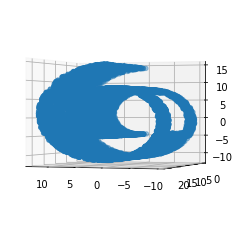

In [50]:
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(swiss[:,0],swiss[:,1],swiss[:,2])
ax.view_init(0,110)

Observation: The persistence diagrams look different for different variations of the swiss role with a hole, even with 0 noise

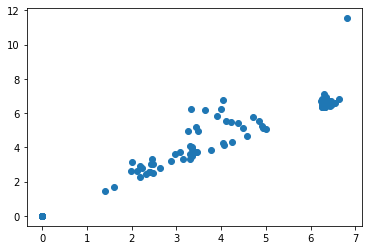

In [23]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = swiss)

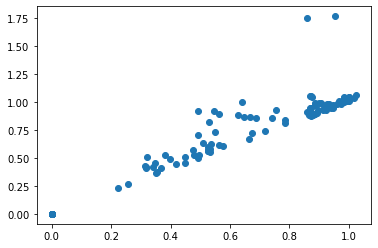

In [40]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = normalize(swiss))

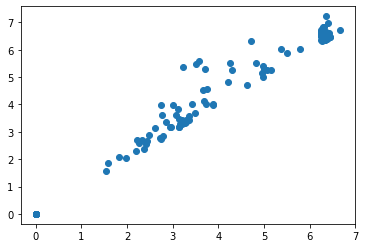

In [42]:
np.random.seed(4)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = swiss)

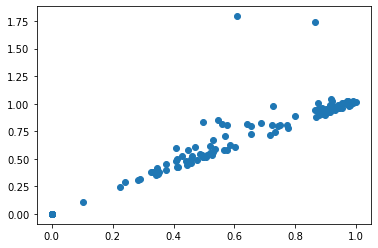

In [43]:
np.random.seed(4)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = normalize(swiss))

They look different

# Functions

In [10]:
def PD(X):
    X = np.array(X, dtype = np.float32) 
    modelR = RipsModel(P=X,X=X, mel=12, dim=1, card = 150)
    Xdgm = modelR.call()[0]
    plt.scatter(Xdgm.numpy()[:,0],Xdgm.numpy()[:,1])
    return 

In [11]:
def plot(X,dim = 3,deg=45):
    
    if dim==3:
        fig = plt.figure(figsize=plt.figaspect(1))
        ax=fig.add_subplot(projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2])
        ax.view_init(0,deg)
        
    return 

# Swiss Role Data

In [8]:
import sklearn.datasets as ds

In [9]:
sr = ds.make_swiss_roll(n_samples=300)[0]

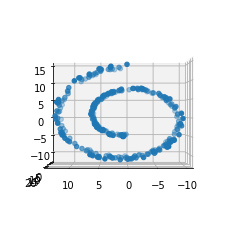

In [10]:
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(sr[:,0],sr[:,1],sr[:,2])
ax.view_init(0,90)

Debug NN
- cylinder
- add layers (depth) not nodes
- scale data
- learning rate


Look at persistence diagram of swiss role without scaling 
Try different scalings on cylinder dataset
- observe what the scale is 

# Mammoth Data Set

In [70]:
import json

In [82]:
# Opening JSON file
f = open('mammoth_3d_50k.json')
 
# returns JSON object as
# a dictionary
mammoth = np.array(json.load(f))

In [95]:
mammoth500 = mammoth[::100]

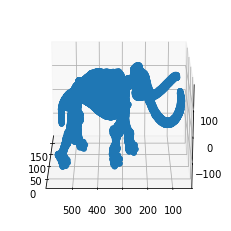

In [91]:
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(mammoth[:,0],mammoth[:,1],mammoth[:,2])
ax.view_init(20,180)

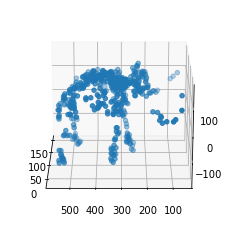

In [96]:
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(mammoth500[:,0],mammoth500[:,1],mammoth500[:,2])
ax.view_init(20,180)

Epoch 1/10


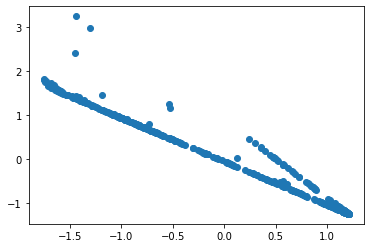

2022-03-24 13:27:18.280702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


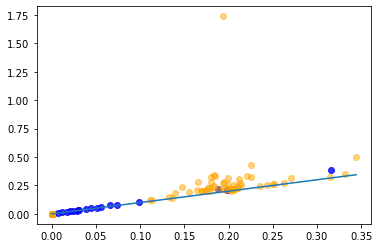

1/1 [==============================] - 20s 20s/step - loss: 1.3118
Epoch 2/10


2022-03-24 13:27:36.736718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


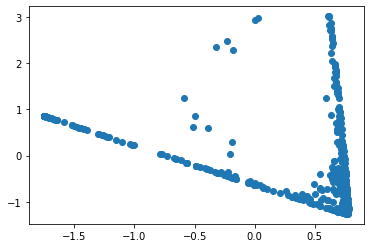

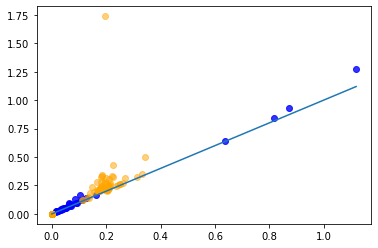

1/1 [==============================] - 18s 18s/step - loss: 1.2145
Epoch 3/10


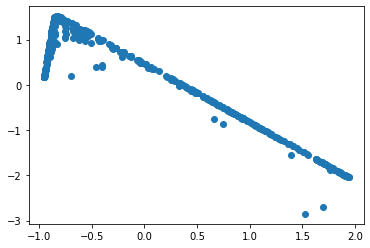

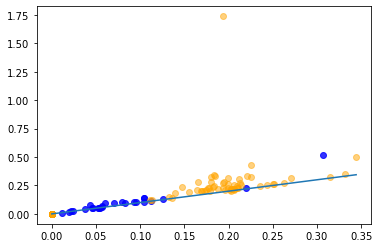

1/1 [==============================] - 19s 19s/step - loss: 1.3169
Epoch 4/10


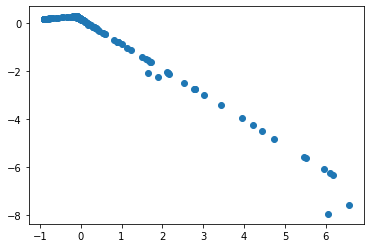

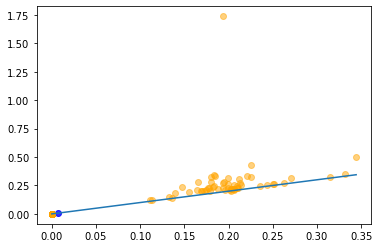

1/1 [==============================] - 18s 18s/step - loss: 1.3262
Epoch 5/10


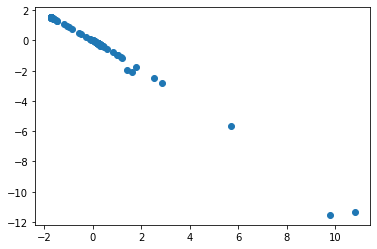

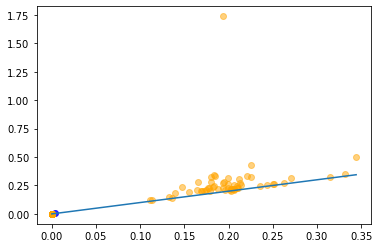

1/1 [==============================] - 18s 18s/step - loss: 1.3262
Epoch 6/10


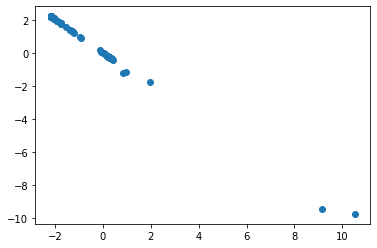

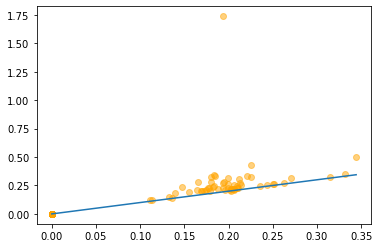

1/1 [==============================] - 18s 18s/step - loss: 1.3262
Epoch 7/10


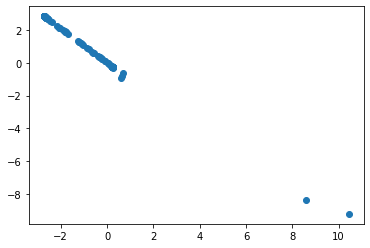

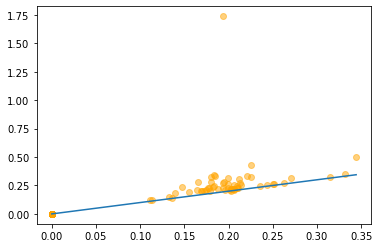

1/1 [==============================] - 19s 19s/step - loss: 1.3262
Epoch 8/10


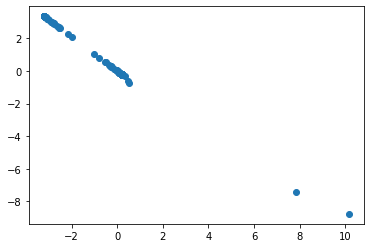

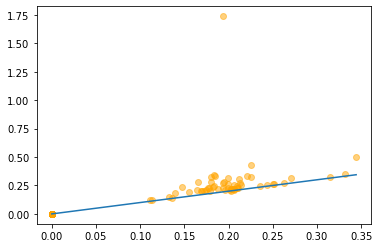

1/1 [==============================] - 19s 19s/step - loss: 1.3262
Epoch 9/10


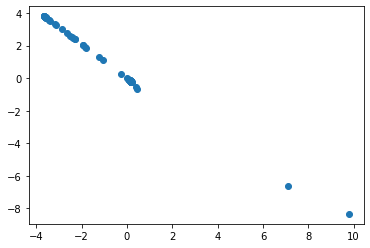

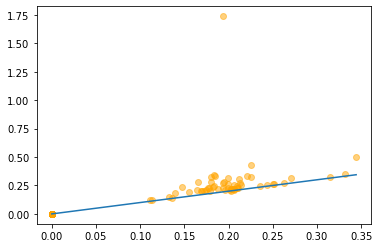

1/1 [==============================] - 19s 19s/step - loss: 1.3262
Epoch 10/10


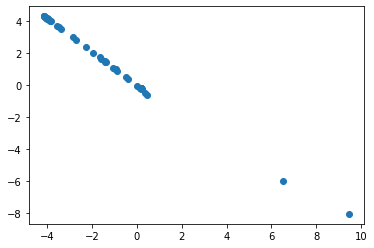

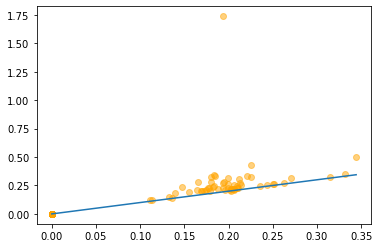

1/1 [==============================] - 19s 19s/step - loss: 1.3262


In [98]:
n_samples = 500

initial_learning_rate =  0.02
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(mammoth500, mammoth500,epochs=10,batch_size=n_samples)

# LOG SCALE PD

In [21]:
def log(X):
    return tf.math.log(X+1) #need the +1 because log(0) = nan

In [15]:
class CustomAccuracy1(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        

        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
#         print("Zdgm",Zdgm)
#         print("log Zdgm",log(Zdgm))
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        #print("D",D)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(log(Zdgm), log(Xdgm), order=2, internal_p=2, enable_autodiff=True))


        return loss

Epoch 1/5


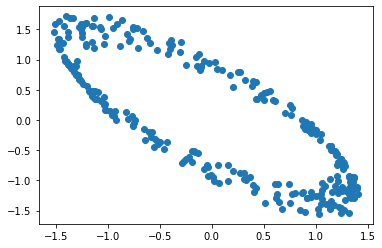

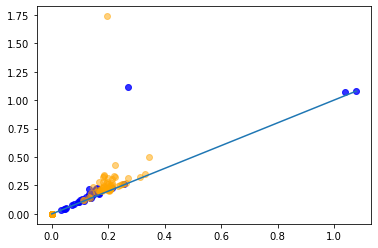

1/1 [==============================] - 5s 5s/step - loss: 0.1453
Epoch 2/5


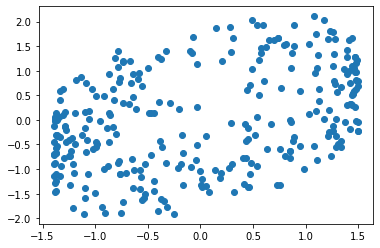

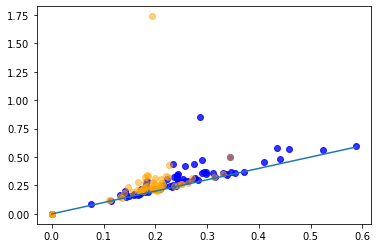

1/1 [==============================] - 6s 6s/step - loss: 0.2146
Epoch 3/5


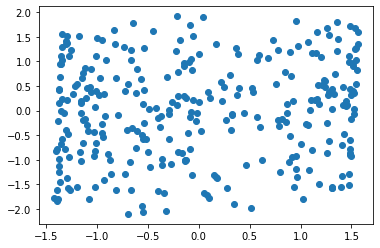

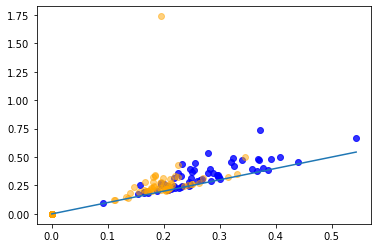

1/1 [==============================] - 6s 6s/step - loss: 0.2992
Epoch 4/5


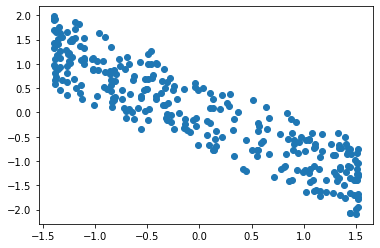

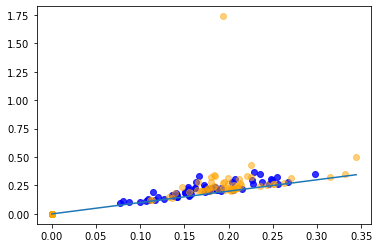

1/1 [==============================] - 6s 6s/step - loss: 0.3690
Epoch 5/5


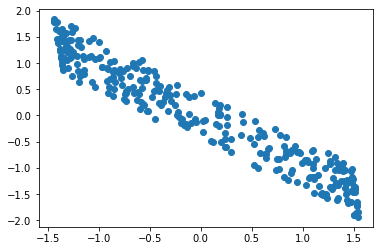

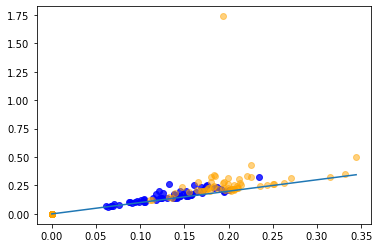

1/1 [==============================] - 6s 6s/step - loss: 0.4033


In [20]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)